In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cell_metrics/supp'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [4]:
%%time
all_fields_recombined_all = {}
pf_params_recombined_all = {}
fr_map_trial_df_all = {}
fr_map_all = {}
occu_map_all = {}
pval_all = {}
best_n_all = {}
X_pwc_all = {}
X_raw_all = {}
changes_df_all = {}
var_res_all = {}
corr_all = {}
all_sw_d_all = {}
all_sw_with_metrics_d_all = {}
trial_index_to_index_within_df_all = {}

spk_beh_df_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        spk_beh_df = res['spk_beh_df']
        spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
        spk_beh_df_all[ani,sess] = spk_beh_df
        trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
        trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        

    pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

    all_fields_recombined=pf_res_recombine['all_fields_recombined']
    all_fields_recombined_all[ani,sess] = all_fields_recombined
    pf_params_recombined = pf_res_recombine['params_recombined']
    pf_params_recombined_all[ani,sess] = pf_params_recombined

    fr_map_res = fmos.main(data_dir_full,force_reload=False,load_only=True)
    fr_map_trial_df = fr_map_res['fr_map_trial_df']
    fr_map_trial_df_all[ani,sess] = fr_map_trial_df
    fr_map = fr_map_res['fr_map']
    fr_map_all[ani,sess] = fr_map
    occu_map = fr_map_res['occu_map']
    occu_map_all[ani,sess] = occu_map



    sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
    pval = sw_res['pval']
    pval_all[ani,sess]=pval
    best_n = sw_res['best_n']
    best_n_all[ani,sess] = best_n
    X_pwc = sw_res['X_pwc']
    X_pwc_all[ani,sess] = X_pwc
    X_raw = sw_res['X_raw']
    X_raw_all[ani,sess]=X_raw
    changes_df = sw_res['changes_df']
    changes_df_all[ani,sess] = changes_df
    var_res = sw_res['var_res']
    var_res_all[ani,sess]=var_res
    corr = sw_res['corr']
    corr_all[ani,sess] = corr

    sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
    if sw_info_res is None:
        sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res['all_sw_d']
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
occu_map_all = pd.concat(occu_map_all,axis=0)
fr_map_all = pd.concat(fr_map_all,axis=0)

pval_all = pd.concat(pval_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
best_n_all = pd.concat(best_n_all,axis=0)

spk_beh_df_all = pd.concat(spk_beh_df_all,axis=0)




/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200802/py_data/place_fie

In [5]:
# ### save all the preprocessed stuff!!!
# import pickle
# prepped_data_agg = {
#     'all_fields_recombined_all':all_fields_recombined_all,
#     'pf_params_recombined_all':pf_params_recombined_all,
#     'fr_map_trial_df_all':fr_map_trial_df_all,
#     'fr_map_all':fr_map_all,
#     'occu_map_all':occu_map_all,
#     'pval_all':pval_all,
#     'X_pwc_all':X_pwc_all,
#     'X_raw_all':X_raw_all,
#     'changes_df_all':changes_df_all,
#     'var_res_all':var_res_all,
#     'corr_all':corr_all,
#     'all_sw_d_all':all_sw_d_all,
#     'all_sw_with_metrics_d_all':all_sw_with_metrics_d_all,
#     'best_n_all':best_n_all,
#     'spk_beh_df_all':spk_beh_df_all,
# }
# fn = 'prepped_data_agg.p'
# fn_full = os.path.join(data_dir,fn)
# pickle.dump(prepped_data_agg,open(fn_full,'wb'))

In [4]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
# X_pwc_all = prepped_data_agg['X_pwc_all']
# X_raw_all = prepped_data_agg['X_raw_all']
# changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
# all_sw_d_all = prepped_data_agg['all_sw_d_all']
# all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [5]:
import glob
cell_metrics_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    
    metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
    cell_metrics_df = pd.DataFrame({k:cell_metrics[k] for k in metrics})
    cell_metrics_df_all[ani,sess] = cell_metrics_df
cell_metrics_df_all = pd.concat(cell_metrics_df_all,axis=0)

cell_metrics_df_all['UID'] = cell_metrics_df_all['UID'].astype(int)
cell_metrics_df_all = cell_metrics_df_all.reset_index(level=2,drop=True).set_index('UID',append=True)

In [157]:
import switch_detection_sweep_penalty_one_session as sdspos
pen=0.5#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/penalty_sw

In [10]:
row_key_l = ['fit_var_ratio','resid2_mean_ratio']

In [12]:
isnovel=0
corr_all.loc[(slice(None),slice(None),isnovel,row_key_l),'mean'].unstack()

fit_var_ratio resid2_mean_ratio
e13_16f1 e13_16f1_210302 0         -0.22              0.22
         e13_16f1_210312 0        -0.058             0.058
         e13_16f1_210314 0        -0.146             0.146
         e13_16f1_210317 0        -0.058             0.058
         e13_16f1_210319 0        -0.059             0.059
         e13_16f1_210322 0        -0.098             0.098
         e13_16f1_210328 0        -0.119             0.119
         e13_16f1_210331 0        -0.128             0.128
e13_26m1 e13_26m1_210913 0        -0.098             0.098
         e13_26m1_211019 0        -0.091             0.091
         e13_26m1_211116 0        -0.107             0.107
         e13_26m1_211119 0        -0.133             0.133
         e13_26m1_211124 0        -0.161             0.161
e14_2m2  e14_2m2_201017  0         -0.05              0.05
         e14_2m2_201019  0        -0.093             0.093
e14_2m3  e14_2m3_201118  0         0.008            -0.008
         e14_2m3_201121  0          -0.2               0.2
         e14_2m3_201125  0        -0.017             0.017
         e14_2m3_201129  0        -0.036             0.036
         e14_2m3_201206  0        -0.113             0.113
         e14_2m3_201208  0         -0.12              0.12
e15_10m1 e15_10m1_200727 0        -0.068             0.068
         e15_10m1_200803 0        -0.347             0.347
         e15_10m1_200809 0        -0.028             0.028
         e15_10m1_200812 0        -0.012             0.012
e15_13f1 e15_13f1_220117 0        -0.099             0.099
         e15_13f1_220118 0          -0.2               0.2
         e15_13f1_220119 0        -0.113             0.113
         e15_13f1_220120 0         -0.03              0.03
e15_9f1  e15_9f1_200715  0         -0.21              0.21
         e15_9f1_200720  0        -0.216             0.216
         e15_9f1_200723  0        -0.228             0.228
         e15_9f1_200729  0        -0.154             0.154
         e15_9f1_200802  0        -0.191             0.191
e16_1f1  e16_1f1_200918  0        -0.148             0.148
         e16_1f1_200919  0        -0.219             0.219
         e16_1f1_200920  0        -0.226             0.226
         e16_1f1_200923  0        -0.317             0.317
         e16_1f1_201004  0        -0.185             0.185
e16_2m1  e16_2m1_201121  0        -0.227             0.227
e16_3m1  e16_3m1_210119  0        -0.117             0.117
         e16_3m1_210201  0        -0.211             0.211
         e16_3m1_210203  0        -0.042             0.042
e16_3m2  e16_3m2_211210  0        -0.246             0.246
         e16_3m2_211212  0        -0.171             0.171
         e16_3m2_211213  0        -0.167             0.167

In [187]:
# field with any switch vs no switch, metrics
task_index=0
cell_with_any_sw_one_task = best_n_all.loc[(slice(None),slice(None),task_index)].groupby(level=(0,1,3)).apply(lambda x:(x>0).any())
cell_metrics_df_all['has_switch']  = cell_with_any_sw_one_task

ma=cell_metrics_df_all['has_switch'].notna()
cell_metrics_df_all_pc = cell_metrics_df_all.loc[ma]

In [15]:
import switch_and_cell_metrics as sacm

In [21]:
pwc_gpb=X_pwc_all.groupby(level=(0,1,2),group_keys=False)
res_all = {}
all_corr_res_all = {}
p_corr_all = {}
for k,val in pwc_gpb:
    res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
    corr_res=sacm.post_decomp_corr(res)
    res_all[k]=res
    all_corr_res_all[k] = corr_res['all_corr']
    p_corr_all[k] = corr_res['p_corr']
res_all = pd.concat(res_all,axis=0)
all_corr_res_all = pd.concat(all_corr_res_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: index

/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_2183249/2005165769.py:6: PerformanceWarning: index

In [23]:
isnovel=0
all_corr_res_all.loc[(slice(None),slice(None),isnovel,row_key_l),'mean'].unstack()

fit_var_ratio resid2_mean_ratio
e13_16f1 e13_16f1_210302 0         -0.22              0.22
         e13_16f1_210312 0        -0.058             0.058
         e13_16f1_210314 0        -0.146             0.146
         e13_16f1_210317 0        -0.058             0.058
         e13_16f1_210319 0        -0.059             0.059
         e13_16f1_210322 0        -0.098             0.098
         e13_16f1_210328 0        -0.119             0.119
         e13_16f1_210331 0        -0.128             0.128
e13_26m1 e13_26m1_210913 0        -0.098             0.098
         e13_26m1_211019 0        -0.091             0.091
         e13_26m1_211116 0        -0.107             0.107
         e13_26m1_211119 0        -0.133             0.133
         e13_26m1_211124 0        -0.161             0.161
e14_2m2  e14_2m2_201017  0         -0.05              0.05
         e14_2m2_201019  0        -0.093             0.093
e14_2m3  e14_2m3_201118  0         0.008            -0.008
         e14_2m3_201121  0          -0.2               0.2
         e14_2m3_201125  0        -0.017             0.017
         e14_2m3_201129  0        -0.036             0.036
         e14_2m3_201206  0        -0.113             0.113
         e14_2m3_201208  0         -0.12              0.12
e15_10m1 e15_10m1_200727 0        -0.068             0.068
         e15_10m1_200803 0        -0.347             0.347
         e15_10m1_200809 0        -0.028             0.028
         e15_10m1_200812 0        -0.012             0.012
e15_13f1 e15_13f1_220117 0        -0.099             0.099
         e15_13f1_220118 0          -0.2               0.2
         e15_13f1_220119 0        -0.113             0.113
         e15_13f1_220120 0         -0.03              0.03
e15_9f1  e15_9f1_200715  0         -0.21              0.21
         e15_9f1_200720  0        -0.216             0.216
         e15_9f1_200723  0        -0.228             0.228
         e15_9f1_200729  0        -0.154             0.154
         e15_9f1_200802  0        -0.191             0.191
e16_1f1  e16_1f1_200918  0        -0.148             0.148
         e16_1f1_200919  0        -0.219             0.219
         e16_1f1_200920  0        -0.226             0.226
         e16_1f1_200923  0        -0.317             0.317
         e16_1f1_201004  0        -0.185             0.185
e16_2m1  e16_2m1_201121  0        -0.227             0.227
e16_3m1  e16_3m1_210119  0        -0.117             0.117
         e16_3m1_210201  0        -0.211             0.211
         e16_3m1_210203  0        -0.042             0.042
e16_3m2  e16_3m2_211210  0        -0.246             0.246
         e16_3m2_211212  0        -0.171             0.171
         e16_3m2_211213  0        -0.167             0.167

In [24]:
all_corr_res_all_selected = all_corr_res_all.loc[(slice(None),slice(None),0),'mean'].unstack()
all_corr_res_all_selected = all_corr_res_all_selected.drop(['mean','tot_var'],axis=1).astype(float)

In [26]:
corr_all_selected = corr_all.loc[(slice(None),slice(None),0),'mean'].unstack()
corr_all_selected = corr_all_selected.drop(['mean','tot_var'],axis=1).astype(float)

[Text(0, 0, 'fit_var'),
 Text(1, 0, 'fit_var_norm'),
 Text(2, 0, 'fit_var_ratio'),
 Text(3, 0, 'resid2_mean'),
 Text(4, 0, 'resid2_mean_norm'),
 Text(5, 0, 'resid2_mean_ratio'),
 Text(6, 0, 'tot_var_norm')]

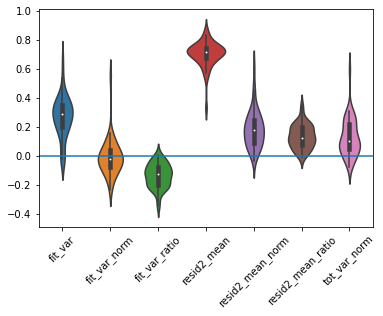

In [27]:
# ax=all_corr_res_all_selected.astype(float).plot(kind='violin')
ax=sns.violinplot(data=corr_all_selected)
ax.axhline(0)
xticklabels=ax.get_xticklabels()
ax.set_xticklabels(xticklabels,rotation=45)

[Text(0, 0, 'fit_var'),
 Text(1, 0, 'resid2_mean'),
 Text(2, 0, 'fit_var_ratio'),
 Text(3, 0, 'resid2_mean_ratio'),
 Text(4, 0, 'tot_var_norm'),
 Text(5, 0, 'fit_var_norm'),
 Text(6, 0, 'resid2_mean_norm')]

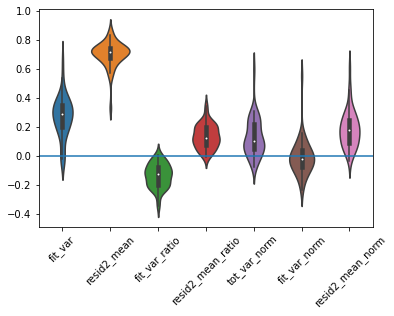

In [25]:
# ax=all_corr_res_all_selected.astype(float).plot(kind='violin')
ax=sns.violinplot(data=all_corr_res_all_selected)
ax.axhline(0)
xticklabels=ax.get_xticklabels()
ax.set_xticklabels(xticklabels,rotation=45)

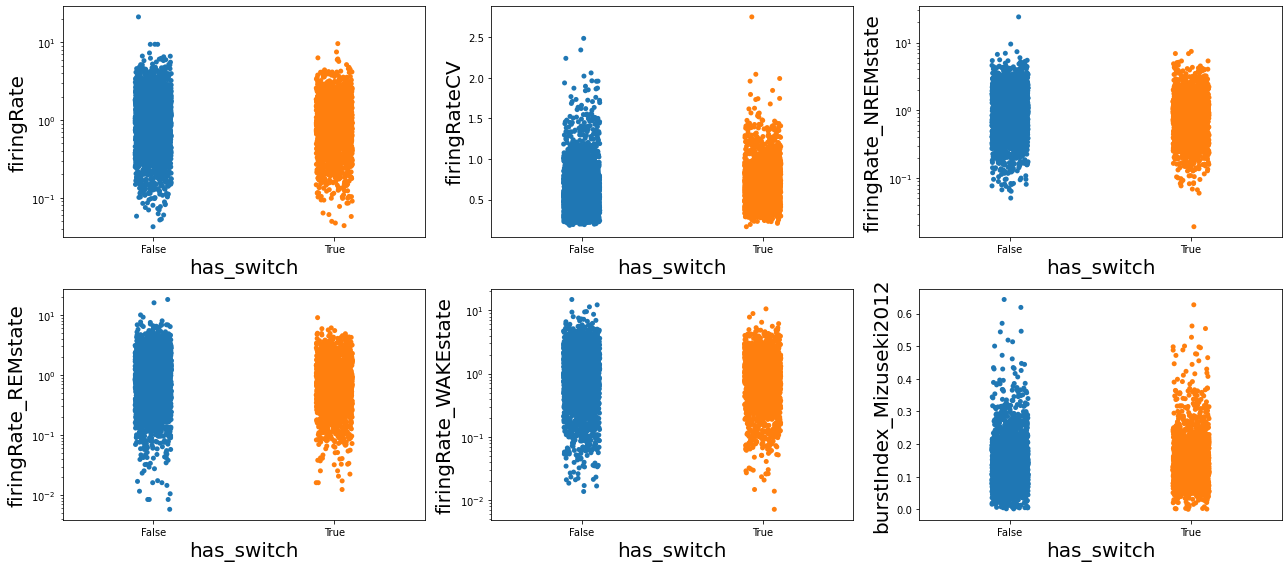

In [188]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.stripplot(ax=ax,x='has_switch',y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

In [36]:
fit_var_ratio_per_uid_mean

e13_16f1  e13_16f1_210302  0  0.0   7      1.562858e-01
                                    8      5.446643e-31
                                    9      3.029259e-01
                                    11     6.486829e-01
                                    12     0.000000e+00
                                               ...     
e16_3m2   e16_3m2_211213   1  both  151    7.409006e-01
                                    157    6.217072e-01
                                    190    5.840231e-01
                                    192    4.350021e-01
                                    195    4.100329e-31
Name: fit_var_ratio, Length: 10164, dtype: float64

In [189]:
fit_var_ratio_per_uid_mean=var_res_all['fit_var_ratio'].groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]
fit_var_ratio_per_uid_max=var_res_all['fit_var_ratio'].groupby(level=(0,1,2,4)).max().loc[(slice(None),slice(None),0)]
fit_var_ratio_per_uid_min=var_res_all['fit_var_ratio'].groupby(level=(0,1,2,4)).min().loc[(slice(None),slice(None),0)]

cell_metrics_df_all_pc['fit_var_ratio_within_neuron_mean'] = fit_var_ratio_per_uid_mean
cell_metrics_df_all_pc['fit_var_ratio_within_neuron_max'] = fit_var_ratio_per_uid_max
cell_metrics_df_all_pc['fit_var_ratio_within_neuron_min'] = fit_var_ratio_per_uid_min

/tmp/ipykernel_2183249/899136052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['fit_var_ratio_within_neuron_mean'] = fit_var_ratio_per_uid_mean
/tmp/ipykernel_2183249/899136052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['fit_var_ratio_within_neuron_max'] = fit_var_ratio_per_uid_max
/tmp/ipykernel_2183249/899136052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

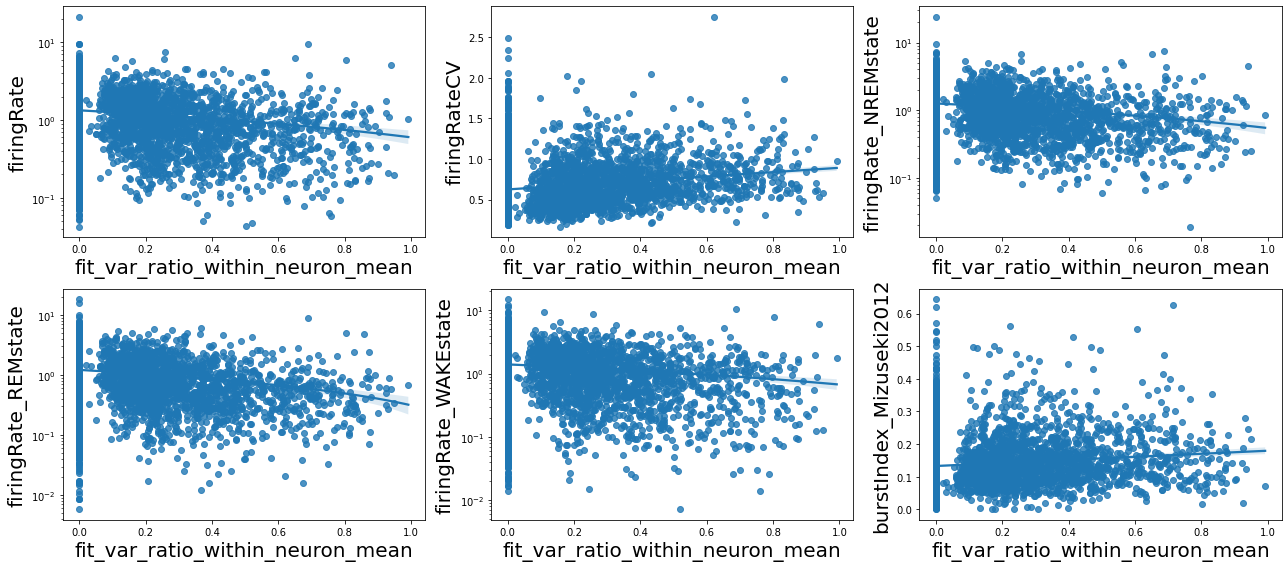

In [190]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x='fit_var_ratio_within_neuron_mean',y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

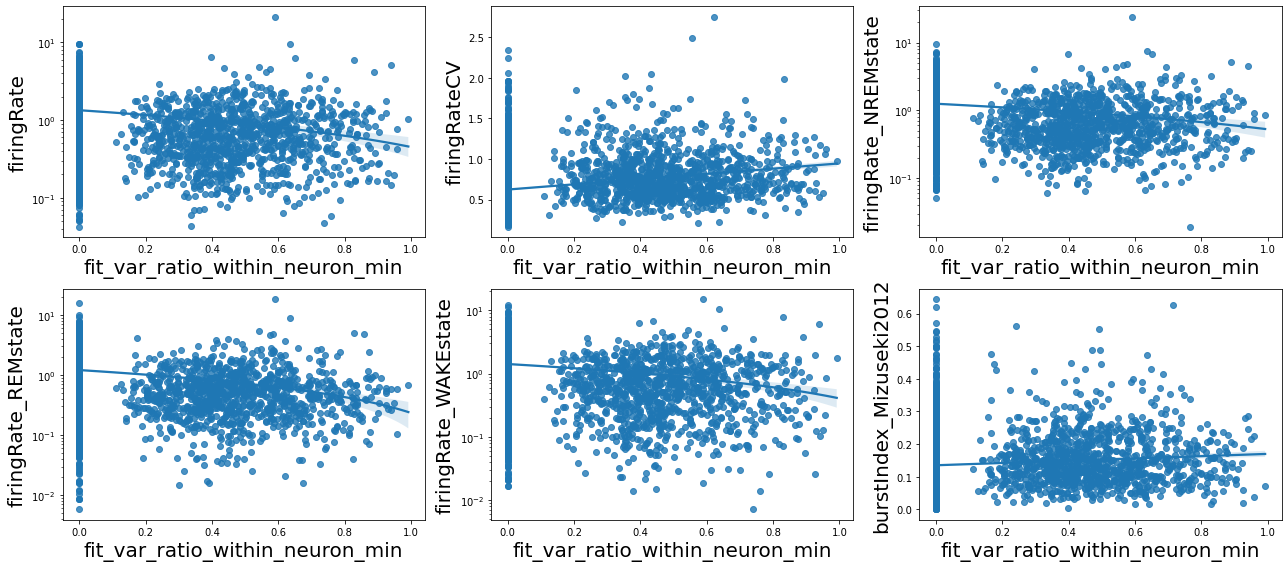

In [83]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x='fit_var_ratio_within_neuron_min',y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

### get the exp var ratio corresponding to best pval 

In [81]:

best_n_if_change=pval_all.loc[:,(slice(None),'pval')].droplevel(1,axis=1).idxmin(axis=1)
inds=pd.MultiIndex.from_frame(best_n_if_change.reset_index())
pval_all_best=pval_all.stack(level=0).loc[inds].droplevel(-1)

<Axes: xlabel='exp_var_ratio', ylabel='exp_var_ratio_sh_med'>

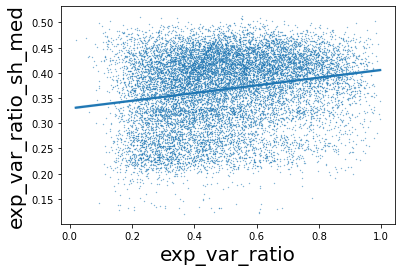

In [98]:
sns.regplot(data=pval_all[2],x='exp_var_ratio',y='exp_var_ratio_sh_med',scatter_kws={'s':0.1})

<Axes: xlabel='exp_var_ratio', ylabel='exp_var_ratio_sh_med'>

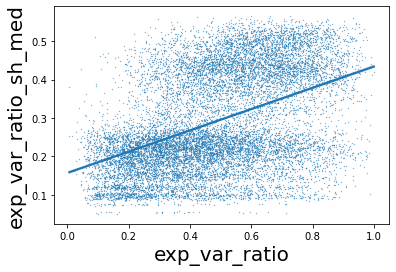

In [95]:
sns.regplot(data=pval_all_best,x='exp_var_ratio',y='exp_var_ratio_sh_med',scatter_kws={'s':0.1})

In [199]:
exp_var_ratio.iloc[:10]

e13_26m1  e13_26m1_210913  0  0.0  3   0    0.491237
                                   27  0    0.000000
                                   29  0    0.624472
                                       1    0.000000
                                       2    0.000000
                                   30  0    0.000000
                                       1    0.000000
                                   31  0    0.541283
                                   32  1    0.000000
                                   33  0    0.000000
Name: exp_var_ratio, dtype: float64

In [206]:
exp_var_ratio.loc['e13_26m1','e13_26m1_210913',0,slice(None),31]

0.0  0    0.541283
1.0  0    0.403005
Name: exp_var_ratio, dtype: float64

In [203]:
exp_var_ratio = copy.copy(pval_all_best['exp_var_ratio'])
# inds=best_n_all.index[best_n_all==0].intersection(exp_var_ratio.index)
inds=best_n_if_change.index[best_n_if_change==0].intersection(exp_var_ratio.index)
exp_var_ratio.loc[inds]=0
best_n_exp_var_ratio_mean=exp_var_ratio.groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]



cell_metrics_df_all_pc['best_n_exp_var_ratio_mean']=best_n_exp_var_ratio_mean


/tmp/ipykernel_2183249/2123994360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['best_n_exp_var_ratio_mean']=best_n_exp_var_ratio_mean


In [205]:
cell_metrics_df_all_pc['best_n_exp_var_ratio_mean']

                           UID
e13_26m1  e13_26m1_210913  3      0.553944
                           27     0.243059
                           29     0.364027
                           30     0.396598
                           31     0.472144
                                    ...   
e14_2m3   e14_2m3_201118   46     0.570169
                           47     0.443970
                           48     0.502762
                           50     0.626858
                           53     0.256682
Name: best_n_exp_var_ratio_mean, Length: 4486, dtype: float64

In [181]:
# ma=cell_metrics_df_all_pc[x]!=0

In [209]:
pd.concat([np.log(cell_metrics_df_all_pc['firingRate']),cell_metrics_df_all_pc[x]],axis=1).rcorr()




firingRate best_n_exp_var_ratio_mean
firingRate                         -                         *
best_n_exp_var_ratio_mean      0.033                         -

In [182]:
pd.concat([np.log(cell_metrics_df_all_pc.loc[ma]['firingRate']),cell_metrics_df_all_pc.loc[ma][x]],axis=1).rcorr()




firingRate best_n_exp_var_ratio_mean
firingRate                         -                       ***
best_n_exp_var_ratio_mean      -0.24                         -

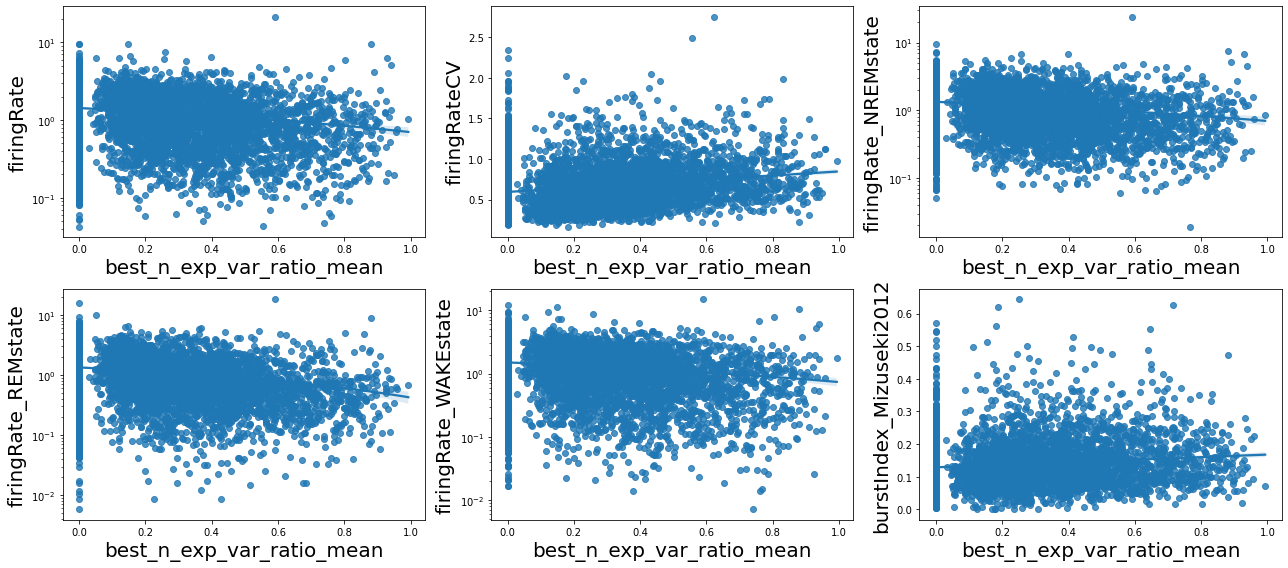

In [183]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='best_n_exp_var_ratio_mean'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

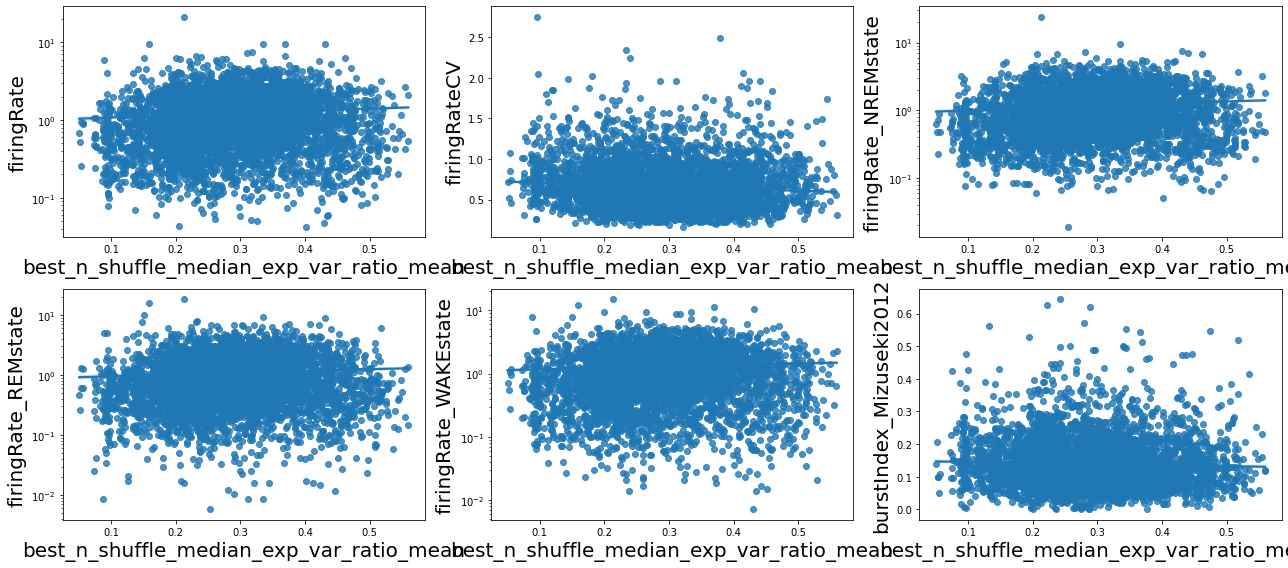

In [90]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='best_n_shuffle_median_exp_var_ratio_mean'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

In [121]:
pval_with_sw=pval_all.stack(level=0).loc[pd.MultiIndex.from_frame(best_n_all_test.loc[best_n_all_test > 0].reset_index())].droplevel(-1)

best_n_has_sw_exp_var_ratio_mean=pval_with_sw['exp_var_ratio'].groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]



cell_metrics_df_all_pc['best_n_has_sw_exp_var_ratio_mean']=best_n_has_sw_exp_var_ratio_mean


/tmp/ipykernel_2183249/1904521304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['best_n_has_sw_exp_var_ratio_mean']=best_n_has_sw_exp_var_ratio_mean


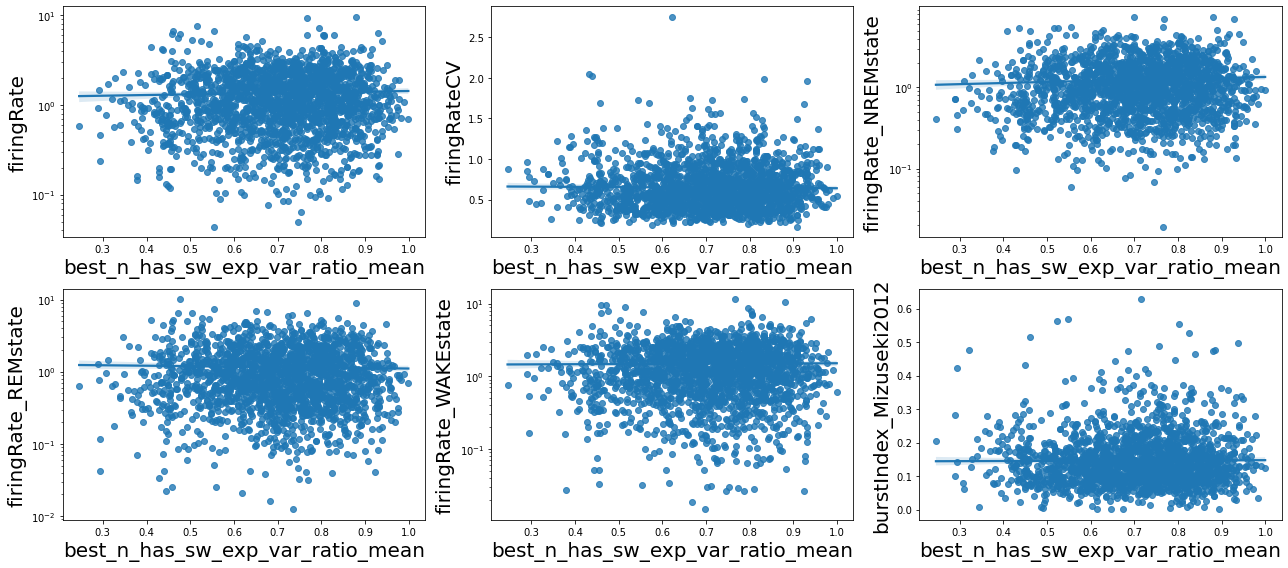

In [122]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='best_n_has_sw_exp_var_ratio_mean'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

# what's the discrepancy between the two methods

In [166]:
agree_ma=(best_n_all>0) == (best_n_all_test > 0)
# agree_ma=best_n_all == best_n_all_test 

In [130]:
best_n_exp_var_ratio_mean_agree_with_pelt =pval_all_best['exp_var_ratio'].loc[agree_ma].groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]

cell_metrics_df_all_pc['best_n_exp_var_ratio_mean_agree_with_pelt']=best_n_exp_var_ratio_mean_agree_with_pelt

/tmp/ipykernel_2183249/3008493325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['best_n_exp_var_ratio_mean_agree_with_pelt']=best_n_exp_var_ratio_mean_agree_with_pelt


In [167]:
# replace no sw ones with exp_var_ratio=0, only on the fields where shuffle and pelt agree
exp_var_ratio_agree = copy.copy(pval_all_best.loc[agree_ma]['exp_var_ratio'])
inds=best_n_all.index[best_n_all==0].intersection(exp_var_ratio_agree.index)
exp_var_ratio_agree.loc[inds]=0
best_n_has_0_exp_var_ratio_mean_agree_with_pelt=exp_var_ratio_agree.groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]
cell_metrics_df_all_pc['best_n_has_0_exp_var_ratio_mean_agree_with_pelt']=best_n_has_0_exp_var_ratio_mean_agree_with_pelt

/tmp/ipykernel_2183249/3820069335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['best_n_has_0_exp_var_ratio_mean_agree_with_pelt']=best_n_has_0_exp_var_ratio_mean_agree_with_pelt


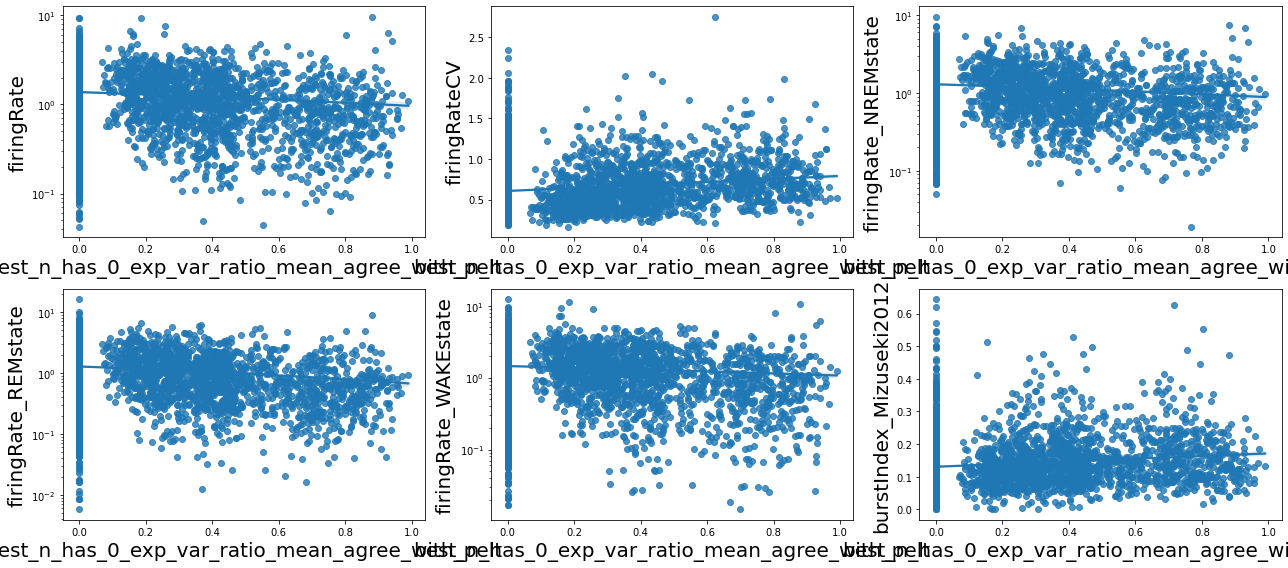

In [168]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='best_n_has_0_exp_var_ratio_mean_agree_with_pelt'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

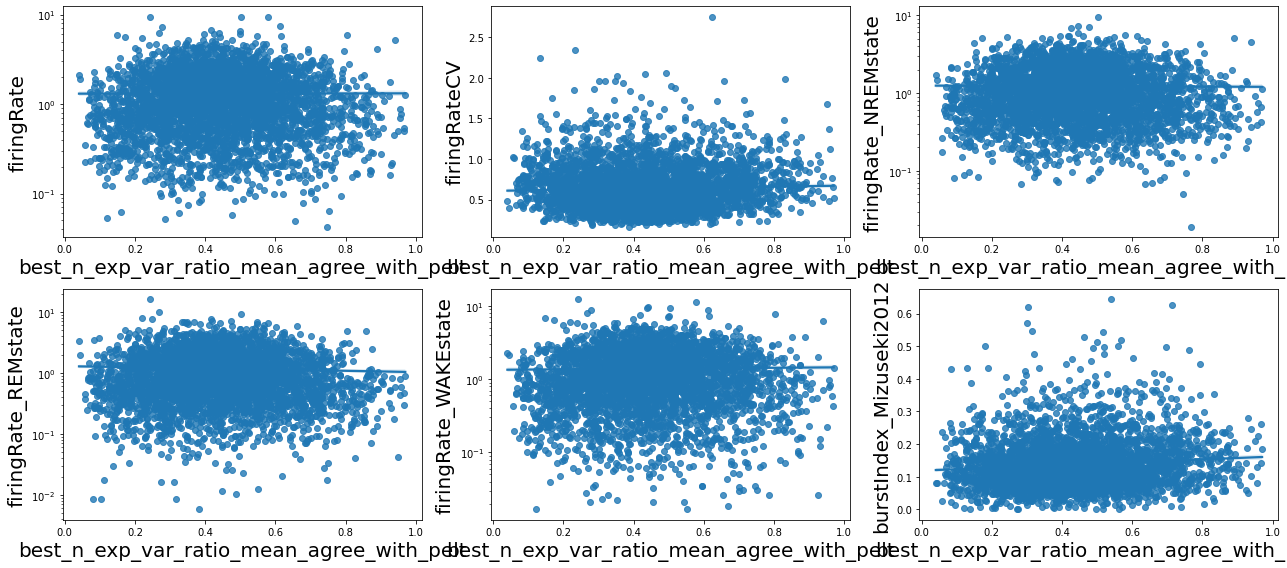

In [131]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='best_n_exp_var_ratio_mean_agree_with_pelt'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

In [ ]:
fit_var_ratio_per_uid_mean_agree=var_res_all['fit_var_ratio'].loc[agree_ma].groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]

cell_metrics_df_all_pc['fit_var_ratio_within_neuron_mean_agree'] = fit_var_ratio_per_uid_mean_agree


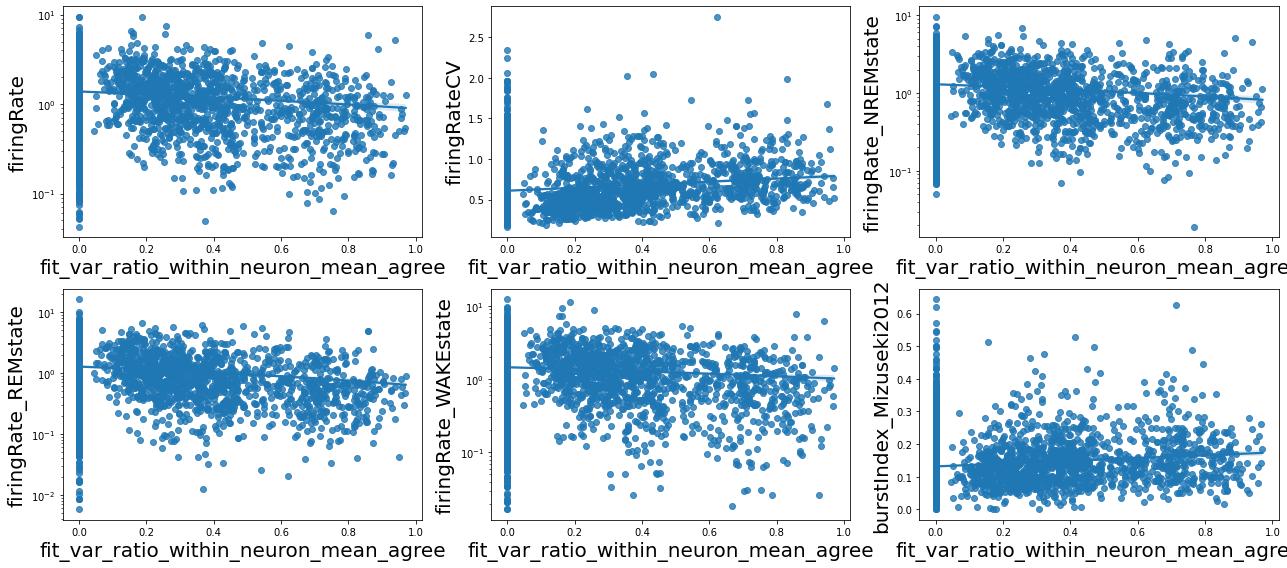

In [142]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
x='fit_var_ratio_within_neuron_mean_agree'
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

[Text(0.5, 0, 'fit var ratio from pelt'),
 Text(0, 0.5, 'exp var ratio from\n best pval shuffle test (agree sw)')]

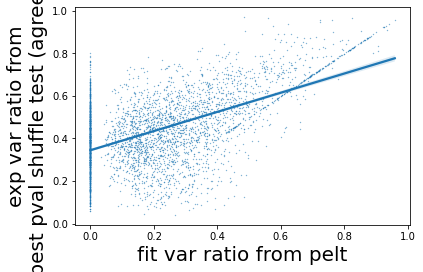

In [132]:
ax=sns.regplot(data=cell_metrics_df_all_pc,x='fit_var_ratio_within_neuron_mean',y='best_n_exp_var_ratio_mean_agree_with_pelt',scatter_kws={'s':0.1})
ax.set(xlabel='fit var ratio from pelt',ylabel='exp var ratio from\n best pval shuffle test (agree sw)')

In [161]:
(~np.isclose(var_res_all.loc[agree_ma]['fit_var_ratio'],exp_var_ratio_agree)).sum()

127

In [144]:
exp_var_ratio_agree = copy.copy(pval_all_best.loc[agree_ma]['exp_var_ratio'])

In [154]:
inds=best_n_all.index[best_n_all==0].intersection(exp_var_ratio_agree.index)
exp_var_ratio_agree.loc[inds]=0

In [155]:
exp_var_ratio_agree

e13_26m1  e13_26m1_210913  0  0.0   27  0    0.000000
                                    29  1    0.000000
                                        2    0.000000
                                    30  0    0.000000
                                        1    0.000000
                                               ...   
e14_2m3   e14_2m3_201118   0  both  19  0    0.000000
                                    22  0    0.565059
                                    30  0    0.000000
                                    47  0    0.000000
                                    53  0    0.000000
Name: exp_var_ratio, Length: 9589, dtype: float64

In [110]:
agree_ma

e13_26m1  e13_26m1_210913  0  0.0   3   0     True
                                    27  0     True
                                    29  0     True
                                        1     True
                                        2     True
                                             ...  
e14_2m3   e14_2m3_201118   0  both  30  0     True
                                    32  0    False
                                    38  0    False
                                    47  0     True
                                    53  0     True
Length: 14438, dtype: bool

In [ ]:
agree_ma

[Text(0.5, 0, 'fit var ratio from pelt'),
 Text(0, 0.5, 'exp var ratio from\n best pval shuffle test')]

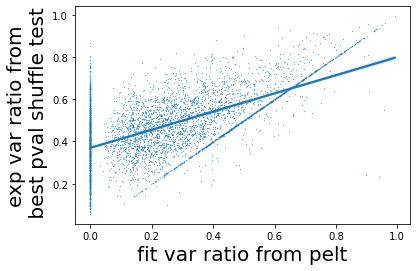

In [114]:
ax=sns.regplot(data=cell_metrics_df_all_pc,x='fit_var_ratio_within_neuron_mean',y='best_n_exp_var_ratio_mean',scatter_kws={'s':0.1})
ax.set(xlabel='fit var ratio from pelt',ylabel='exp var ratio from\n best pval shuffle test')

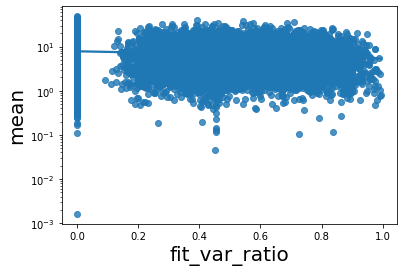

In [185]:
ax=sns.regplot(data=var_res_all,x='fit_var_ratio',y='mean')
ax.set_yscale('log')

# fields differentially classified

In [251]:
# ma = (best_n_all == 0) & (best_n_all_test>0)
# ma = (best_n_all > 0) & (best_n_all_test==0)
ma = (best_n_all == 0) & (best_n_all_test==0)

In [249]:
# var_res_all_test.loc[ma][['fit_var_ratio','mean']].rcorr()
var_res_all.loc[ma][['fit_var_ratio','mean']].rcorr()

fit_var_ratio mean
fit_var_ratio             -    *
mean                 -0.067    -

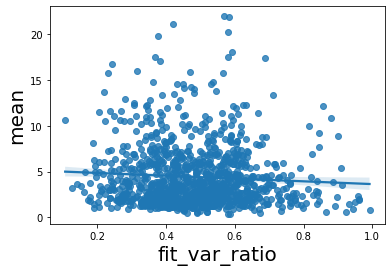

In [250]:
# ax=sns.regplot(data=var_res_all_test.loc[ma],x='fit_var_ratio',y='mean')
ax=sns.regplot(data=var_res_all.loc[ma],x='fit_var_ratio',y='mean')
# ax.set(yscale='log')


In [231]:
ma.sum()

1083

In [236]:
X_pwc_all.loc[ma].iloc[:30]

0          1   2          3   4   5   \
e13_26m1 e13_26m1_210913 0 0.0 32  1 NaN  10.103403 NaN  10.103403 NaN NaN   
                               33  0 NaN  13.916078 NaN  13.916078 NaN NaN   
                               43  1 NaN  16.324995 NaN  16.324995 NaN NaN   
                               52  2 NaN   8.804324 NaN   8.804324 NaN NaN   
                               53  2 NaN  10.668316 NaN  10.668316 NaN NaN   
                               67  1 NaN   7.376680 NaN   7.376680 NaN NaN   
                               85  0 NaN  19.573537 NaN  19.573537 NaN NaN   
                               88  2 NaN  18.049990 NaN  18.049990 NaN NaN   
                               92  1 NaN   8.559265 NaN   8.559265 NaN NaN   
                               94  2 NaN   8.703388 NaN   8.703388 NaN NaN   
                               96  0 NaN  11.869066 NaN  11.869066 NaN NaN   
                               103 1 NaN   6.251435 NaN   6.251435 NaN NaN   
                               109 0 NaN   4.982925 NaN   4.982925 NaN NaN   
                               120 0 NaN   2.662681 NaN   2.662681 NaN NaN   
                               126 0 NaN  20.573412 NaN  20.573412 NaN NaN   
                               129 0 NaN  24.007720 NaN  24.007720 NaN NaN   
                               145 0 NaN   9.405686 NaN   9.405686 NaN NaN   
                               162 0 NaN   5.052338 NaN   5.052338 NaN NaN   
                               166 1 NaN   7.424573 NaN   7.424573 NaN NaN   
                               181 2 NaN   7.117829 NaN   7.117829 NaN NaN   
                               195 1 NaN   5.188165 NaN   5.188165 NaN NaN   
                               200 1 NaN   3.299268 NaN   3.299268 NaN NaN   
                               211 1 NaN  21.870553 NaN  21.870553 NaN NaN   
                               213 1 NaN  11.896695 NaN  11.896695 NaN NaN   
                               225 0 NaN  29.915268 NaN  29.915268 NaN NaN   
                               232 0 NaN  13.244484 NaN  13.244484 NaN NaN   
                               269 0 NaN  23.346161 NaN  23.346161 NaN NaN   
                               300 0 NaN  17.337982 NaN  17.337982 NaN NaN   
                               325 0 NaN   1.515280 NaN   1.515280 NaN NaN   
                               332 1 NaN  11.715493 NaN  11.715493 NaN NaN   

                                             6   7          8   9   ...  60  \
e13_26m1 e13_26m1_210913 0 0.0 32  1  10.103403 NaN  10.103403 NaN  ... NaN   
                               33  0  13.916078 NaN  13.916078 NaN  ... NaN   
                               43  1  16.324995 NaN  16.324995 NaN  ... NaN   
                               52  2   8.804324 NaN   8.804324 NaN  ... NaN   
                               53  2  10.668316 NaN  10.668316 NaN  ... NaN   
                               67  1   7.376680 NaN   7.376680 NaN  ... NaN   
                               85  0  19.573537 NaN  19.573537 NaN  ... NaN   
                               88  2  18.049990 NaN  18.049990 NaN  ... NaN   
                               92  1   8.559265 NaN   8.559265 NaN  ... NaN   
                               94  2   8.703388 NaN   8.703388 NaN  ... NaN   
                               96  0  11.869066 NaN  11.869066 NaN  ... NaN   
                               103 1   6.251435 NaN   6.251435 NaN  ... NaN   
                               109 0   4.982925 NaN   4.982925 NaN  ... NaN   
                               120 0   2.662681 NaN   2.662681 NaN  ... NaN   
                               126 0  20.573412 NaN  20.573412 NaN  ... NaN   
                               129 0  24.007720 NaN  24.007720 NaN  ... NaN   
                               145 0   9.405686 NaN   9.405686 NaN  ... NaN   
                               162 0   5.052338 NaN   5.052338 NaN  ... NaN   
                               166 1   7.424573 NaN   7.424573 NaN  ... NaN   
                               181 2   

[None]

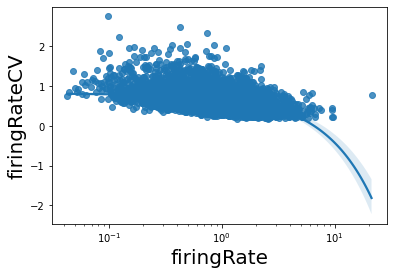

In [256]:
ax=sns.regplot(data=cell_metrics_df_all_pc,x='firingRate',y='firingRateCV')
ax.set(xscale='log')

In [252]:
X_raw_all.loc[ma].iloc[:30]

0          1   2          3   4   5   \
e13_26m1 e13_26m1_210913 0 0.0 27 0 NaN  25.437013 NaN  21.112812 NaN NaN   
                               29 1 NaN  25.426426 NaN  22.606144 NaN NaN   
                                  2 NaN   6.629354 NaN  31.612912 NaN NaN   
                               30 0 NaN  19.478041 NaN   3.109505 NaN NaN   
                                  1 NaN   6.839922 NaN   5.105462 NaN NaN   
                               33 1 NaN   7.895124 NaN   5.117142 NaN NaN   
                               34 0 NaN   3.961978 NaN   0.000000 NaN NaN   
                                  1 NaN   9.045711 NaN   6.329686 NaN NaN   
                               36 1 NaN  22.667654 NaN  19.488060 NaN NaN   
                               39 0 NaN  13.213558 NaN   4.837919 NaN NaN   
                               40 0 NaN   0.431597 NaN   1.111473 NaN NaN   
                               41 0 NaN   0.295504 NaN   0.000527 NaN NaN   
                               43 0 NaN   4.390036 NaN   2.107087 NaN NaN   
                                  2 NaN   8.889257 NaN   9.171074 NaN NaN   
                               44 1 NaN   6.608041 NaN  10.458990 NaN NaN   
                                  2 NaN  11.465634 NaN   9.639584 NaN NaN   
                               45 0 NaN  37.679282 NaN  38.415949 NaN NaN   
                                  2 NaN  19.840804 NaN  16.108973 NaN NaN   
                               46 1 NaN   2.829663 NaN   6.661549 NaN NaN   
                               52 0 NaN  15.939762 NaN  11.390122 NaN NaN   
                                  1 NaN  14.009950 NaN  20.138635 NaN NaN   
                               53 1 NaN  31.537153 NaN  18.338837 NaN NaN   
                               54 1 NaN   5.089245 NaN   1.211921 NaN NaN   
                                  2 NaN  10.286989 NaN   7.534443 NaN NaN   
                               56 1 NaN   7.337120 NaN   5.250835 NaN NaN   
                               57 1 NaN   1.744947 NaN  13.156982 NaN NaN   
                               58 0 NaN   0.000000 NaN   5.276795 NaN NaN   
                                  1 NaN   2.051635 NaN   3.198979 NaN NaN   
                               62 1 NaN  28.222643 NaN  35.449388 NaN NaN   
                                  2 NaN  32.385196 NaN  39.006085 NaN NaN   

                                            6   7          8   9   ...  60  \
e13_26m1 e13_26m1_210913 0 0.0 27 0  35.841307 NaN  29.787902 NaN  ... NaN   
                               29 1  34.580452 NaN  33.254925 NaN  ... NaN   
                                  2  20.232920 NaN  11.154519 NaN  ... NaN   
                               30 0   9.231314 NaN  11.315227 NaN  ... NaN   
                                  1   9.421650 NaN   3.588356 NaN  ... NaN   
                               33 1   6.806616 NaN   4.025327 NaN  ... NaN   
                               34 0   4.945522 NaN   5.490498 NaN  ... NaN   
                                  1   3.974582 NaN   5.043884 NaN  ... NaN   
                               36 1   6.498500 NaN  22.720996 NaN  ... NaN   
                               39 0   3.888729 NaN  12.875003 NaN  ... NaN   
                               40 0   7.779347 NaN  16.067856 NaN  ... NaN   
                               41 0   0.631227 NaN   0.000000 NaN  ... NaN   
                               43 0   3.842333 NaN   4.419090 NaN  ... NaN   
                                  2  12.185043 NaN   8.731017 NaN  ... NaN   
                               44 1   2.828195 NaN   5.103171 NaN  ... NaN   
                                  2  24.928021 NaN  18.784470 NaN  ... NaN   
                               45 0  36.484548 NaN  42.575915 NaN  ... NaN   
                                  2  14.377904 NaN   6.760394 NaN  ... NaN   
                               46 1   5.805569 NaN   6.712542 NaN  ... NaN   
                               52 0  16.850183 NaN  13.849683 NaN  ... NaN   
           

In [225]:
toplot.loc[toplot['theta_phase']<0]

lin  theta_phase
1065    38.549851    -2.577731
1080    64.161132    -2.713237
1167   111.760273    -1.651421
1409   112.963779    -2.520607
1478   117.004121    -2.943622
...           ...          ...
63461  193.790333    -0.707121
63475  193.790333    -2.037743
63481  193.790333    -2.889000
63489  207.675465    -0.543586
63529  218.319948    -1.852845

[356 rows x 2 columns]

/tmp/ipykernel_2183249/61258690.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df=spk_beh_df_all.loc[ani,sess]


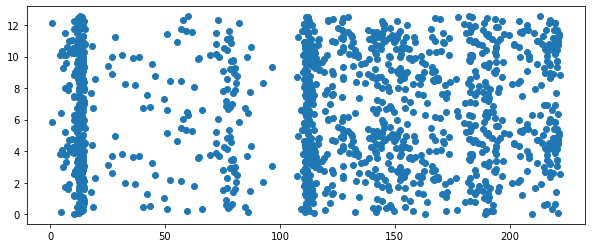

In [227]:
ani='e13_26m1'
sess='e13_26m1_210913'
spk_beh_df=spk_beh_df_all.loc[ani,sess]
spk_beh_df_sub = spk_beh_df.loc[spk_beh_df['trial_type']==(0,0)]
fig,ax=plt.subplots(figsize=(10,4))
toplot=copy.copy(spk_beh_df_sub.loc[spk_beh_df_sub[114]>0])[['lin','theta_phase']]
toplot_2=copy.copy(toplot)
toplot_2['theta_phase'] = toplot_2['theta_phase'] + np.pi * 2
toplot.loc[toplot['theta_phase']<0,'theta_phase'] = toplot.loc[toplot['theta_phase']<0,'theta_phase']+np.pi*4
toplot_tot=pd.concat([toplot,toplot_2],axis=0)
ax.scatter(toplot_tot['lin'],toplot_tot['theta_phase'])


# include all metrics as features to find axis for classification

### lap-to-lap correlation

In [411]:
def stability_by_corr_one_cell(mat):
    '''
    mat: npos x ntrial
    '''
    corr=mat.dropna(axis=1).corr().values
    corr_triu_flatten=corr[np.triu_indices(corr.shape[0],k=1)]
    return np.nanmedian(corr_triu_flatten)
    

gpb=fr_map_trial_df_all.groupby(level=(0,1,2,3,4),sort=False)
stab_all = gpb.apply(stability_by_corr_one_cell)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### frac trial active

In [27]:
frac_trial_active=X_raw_all.groupby(level=(0,1,2,3),group_keys=False,sort=False).apply(lambda x:(x.dropna(axis=1)>active_thresh).mean(axis=1))





### fr cv

In [29]:
fr_cv_beh = X_raw_all.std(axis=1)/X_raw_all.mean(axis=1)

### loc std

In [150]:
loc_key = 'peak'
loc_std = pf_params_recombined_all.loc[(slice(None),slice(None),loc_key),:].std(axis=1).droplevel(2)

### spatial information

In [80]:
gpb = spk_beh_df_all.groupby(level=(0,1),sort=False)

reload(pa)
s_i_all = {}
for k,val in gpb:
    cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
    s_i = pa.get_bits_per_spike(val.loc[k],cell_cols=cell_cols,gauss_width = 2.5,speed_key = 'directed_locomotion',speed_thresh = 0.5,
                       trialtype_key='trial_type',
                    )
    s_i_all[k]=s_i
s_i_all = pd.concat(s_i_all,axis=0)

In [130]:
s_i_all

e13_26m1  e13_26m1_210913  0  0.0  1.0     1.609414
                                   2.0          NaN
                                   3.0     3.372180
                                   27.0    0.026260
                                   29.0    0.979341
                                             ...   
e14_2m3   e14_2m3_201118   0  1.0  48.0    0.154151
                                   50.0    0.627549
                                   52.0    1.521030
                                   53.0    0.219947
                                   54.0    0.445532
Length: 14610, dtype: float64

### field_width

In [132]:
field_width_all = all_fields_recombined_all['end']-all_fields_recombined_all['start']

### together

In [160]:
# per field properties
per_field_var_metrics=\
{
'frac_trial_active':frac_trial_active,
'fr_cv_beh':fr_cv_beh,
'loc_std':loc_std,
'field_width':field_width_all,
}
per_field_var_metrics = pd.concat(per_field_var_metrics,axis=1)

per_field_var_metrics = pd.concat([per_field_var_metrics,var_res_all],axis=1)

per_field_var_metrics['log_mean'] = np.log(per_field_var_metrics['mean'])

In [431]:
# per tt-neuron property
per_tt_neuron_metrics=pd.concat({'lap_correlation':stab_all,\
 'si':s_i_all},axis=1)

# assign tt-neuron property to field


gpb = per_field_var_metrics.groupby(level=(0,1,2,3,4),sort=False)
per_tt_neuron_metrics_expanded = {}
# for k,val in gpb:
for k,row in per_field_var_metrics.iterrows():
    ani,sess,ti,tt,uid,field_id=k
    if tt=='both':
        tt = slice(None)
        row=per_tt_neuron_metrics.loc[(ani,sess,ti,tt,uid)].mean(axis=0)
    else:
        row=per_tt_neuron_metrics.loc[(ani,sess,ti,tt,uid)]
    
    per_tt_neuron_metrics_expanded[k]=row
per_tt_neuron_metrics_expanded=pd.concat(per_tt_neuron_metrics_expanded,axis=0).unstack()

In [432]:
per_field_metrics_all = pd.concat([per_field_var_metrics,per_tt_neuron_metrics_expanded],axis=1)

<Axes: xlabel='lap_correlation', ylabel='si'>

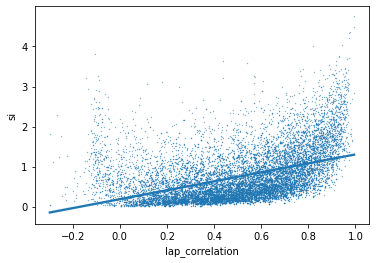

In [435]:
sns.regplot(data=per_field_metrics_all,x='lap_correlation',y='si',scatter_kws={'s':0.1})

In [406]:
val

frac_trial_active  fr_cv_beh   loc_std  \
e16_3m2 e16_3m2_211213 1 both 195 0           0.931034   0.539361  1.473911   

                                    field_width    tot_var      mean  \
e16_3m2 e16_3m2_211213 1 both 195 0           5  17.315069  7.851493   

                                          fit_var  resid2_mean  fit_var_ratio  \
e16_3m2 e16_3m2_211213 1 both 195 0  7.099748e-30    17.315069   4.100329e-31   

                                     resid2_mean_ratio  tot_var_norm  \
e16_3m2 e16_3m2_211213 1 both 195 0                1.0      2.205322   

                                     fit_var_norm  resid2_mean_norm  log_mean  
e16_3m2 e16_3m2_211213 1 both 195 0  9.042545e-31          2.205322  2.060704

In [449]:
per_field_var_metrics.index.get_level_values(1).unique()

Index(['e13_26m1_210913', 'e15_13f1_220117', 'e15_13f1_220118',
       'e15_13f1_220119', 'e15_13f1_220120', 'e13_26m1_211019',
       'e13_16f1_210328', 'e13_26m1_211116', 'e16_3m2_211213',
       'e16_3m2_211212', 'e16_3m1_210203', 'e16_3m2_211210', 'e13_26m1_211119',
       'e13_26m1_211124', 'e16_3m1_210201', 'e13_16f1_210331',
       'e16_3m1_210119', 'e13_16f1_210302', 'e13_16f1_210317',
       'e13_16f1_210312', 'e15_10m1_200809', 'e15_10m1_200812',
       'e13_16f1_210314', 'e15_9f1_200729', 'e14_2m2_201019',
       'e13_16f1_210319', 'e13_16f1_210322', 'e15_10m1_200727',
       'e14_2m2_201017', 'e16_1f1_201004', 'e16_1f1_200920', 'e15_9f1_200723',
       'e14_2m3_201129', 'e14_2m3_201125', 'e16_1f1_200918', 'e16_1f1_200919',
       'e14_2m3_201208', 'e14_2m3_201206', 'e15_9f1_200802', 'e16_1f1_200923',
       'e15_9f1_200720', 'e16_2m1_201121', 'e15_10m1_200803', 'e15_9f1_200715',
       'e14_2m3_201121', 'e14_2m3_201118'],
      dtype='object')

In [437]:
per_field_metrics_all.columns

Index(['frac_trial_active', 'fr_cv_beh', 'loc_std', 'field_width', 'tot_var',
       'mean', 'fit_var', 'resid2_mean', 'fit_var_ratio', 'resid2_mean_ratio',
       'tot_var_norm', 'fit_var_norm', 'resid2_mean_norm', 'log_mean',
       'lap_correlation', 'si'],
      dtype='object')

In [531]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA,NMF
from sklearn.pipeline import Pipeline


sess = 'e13_26m1_210913'#'e15_13f1_220117'#
# data = per_field_var_metrics.loc[:,per_field_var_metrics.columns!='tot_var']
# data = per_field_var_metrics.loc[(slice(None),sess),~per_field_var_metrics.columns.isin(['tot_var','mean'])]
# feat_col = ['frac_trial_active','fr_cv_beh','loc_std','field_width','tot_var_norm','fit_var_ratio','log_mean','lap_correlation','si']
feat_col = ['frac_trial_active','fr_cv_beh','loc_std','fit_var_ratio','resid2_mean_norm','lap_correlation']
# data = per_field_var_metrics.loc[(slice(None),sess),~per_field_var_metrics.columns.isin(['tot_var','mean'])]
data = per_field_metrics_all.loc[(slice(None),sess),feat_col]


data_norm = StandardScaler().fit_transform(data)
# data_norm = MinMaxScaler().fit_transform(data)
data_norm = pd.DataFrame(data_norm,columns=data.columns,index=data.index)

model = PCA(n_components=3)
# model = NMF(n_components=3)

# W = model.fit_transform(data_norm)
# H = model.components_

import nmf_analysis as na
n_components=3
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(data_norm.values,n_components,model=model)


(<Figure size 324x1180.8 with 4 Axes>,
 {'W': <Axes: label='W', xlabel='component', ylabel='neuron'>,
  'H': <Axes: label='H', ylabel='component'>})

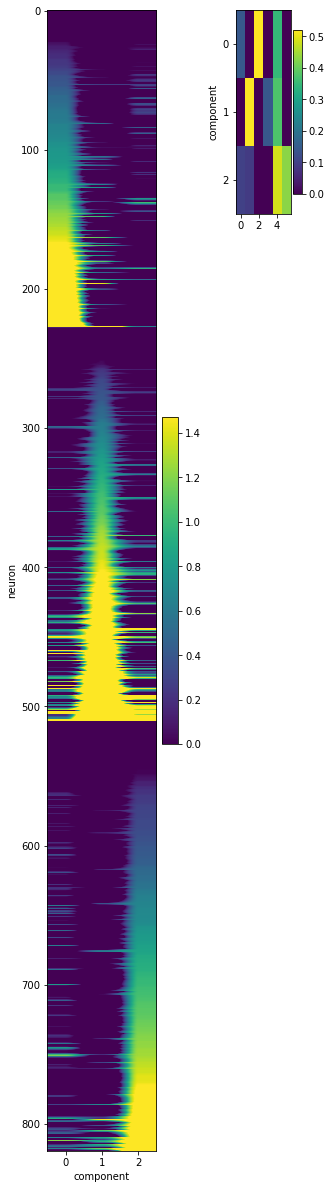

In [532]:
import nmf_plot as nmfp
nmfp.plot_wh(W_sorted,H_sorted)

In [330]:
# %%time
# from sklearn.manifold import TSNE
# model = TSNE(n_components=3,perplexity=3)
# W = model.fit_transform(data_norm)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  self.min_grad_norm = min_grad_norm
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  


CPU times: user 26 s, sys: 1.25 ms, total: 26 s
Wall time: 6.52 s


In [533]:
# has_sw_one = (best_n_all.loc[(slice(None),sess)] > 0).astype(int)
# color = has_sw_one.apply(lambda x:f'C{x}')
x = 'lap_correlation'#'si'#'log_mean'#'loc_std'#'tot_var_norm'#'fit_var_ratio'#
colors = data[x].values.astype(float)
color_discrete = False

In [534]:
cmap = plt.get_cmap('jet')
if color_discrete:
    levels = MaxNLocator(nbins=int(cmax-cmin+1)).tick_values(cmin,cmax+1)
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
else:
    cmin,cmax=np.min(colors),np.max(colors)
    norm = plt.Normalize(cmin, cmax)
c = cmap(norm(colors))

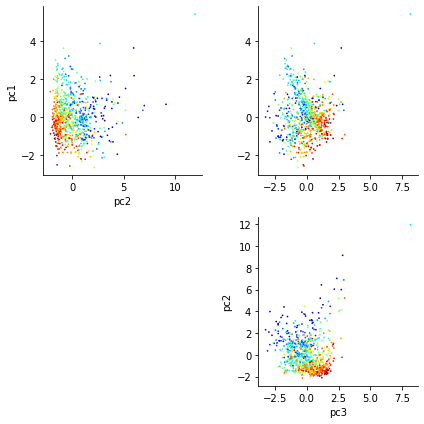

In [535]:
fig,axs=plt.subplots(2,2,figsize=(6,6))
s=0.5
ax=axs[0,0]
ax.scatter(W[:,1],W[:,0],c=c,s=s)
ax.set_ylabel('pc1')
ax.set_xlabel('pc2')
ax=axs[0,1]
ax.scatter(W[:,2],W[:,0],c=c,s=s)
ax=axs[1,1]
ax.scatter(W[:,2],W[:,1],c=c,s=s)
ax.set_xlabel('pc3')
ax.set_ylabel('pc2')
ax=axs[1,0]
ax.set_axis_off()
sns.despine()
plt.tight_layout()

<Axes: >

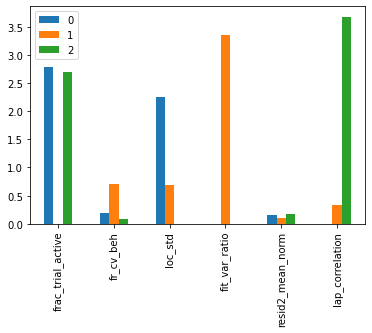

In [524]:
# H_df=pd.DataFrame(H,columns=data.columns)
H_df=pd.DataFrame(H_sorted,columns=data.columns)
H_df.T.plot(kind='bar')

<Axes: >

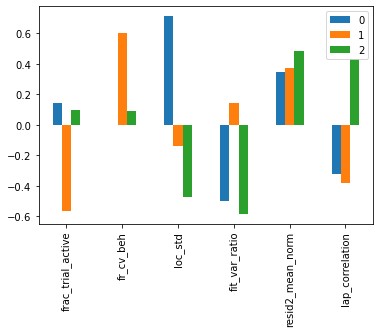

In [536]:
# H_df=pd.DataFrame(H,columns=data.columns)
H_df=pd.DataFrame(H_sorted,columns=data.columns)
H_df.T.plot(kind='bar')

In [444]:
from scipy.spatial.distance import pdist, squareform
import tsp
w_dist=squareform(pdist(W))
tsp_inds,_=tsp.solve_tsp(w_dist)

W_df = pd.DataFrame(W,index=data.index)

W_df_tsp = W_df.iloc[tsp_inds]

In [403]:
data_norm.iloc[tsp_inds].iloc[:12]

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  335 1           0.657407   0.101149  0.353487   
                                386 1           0.657407   0.160704  0.251635   
                           1.0  68  2           0.638889   0.151435  0.295184   
                                155 1           0.555556   0.141030  0.278280   
                                68  4           0.694444   0.146849  0.237719   
                           both 82  0           0.721032   0.165436  0.481444   
                           1.0  459 0           0.888889   0.096516  0.265281   
                                284 0           0.777778   0.109261  0.304397   
                                68  1           0.694444   0.142749  0.400975   
                                206 2           0.694444   0.103888  0.389529   
                                335 1           0.638889   0.119865  0.440581   
                           0.0  123 1           0.563973   0.148084  0.544695   

                                       field_width  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  335 1     0.269231      0.085049   
                                386 1     0.192308      0.144943   
                           1.0  68  2     0.115385      0.186358   
                                155 1     0.115385      0.200711   
                                68  4     0.076923      0.182159   
                           both 82  0     0.038462      0.351316   
                           1.0  459 0     0.461538      0.224440   
                                284 0     0.307692      0.223092   
                                68  1     0.230769      0.203514   
                                206 2     0.307692      0.140041   
                                335 1     0.384615      0.149125   
                           0.0  123 1     0.384615      0.196139   

                                       fit_var_ratio  log_mean  
e13_26m1 e13_26m1_210913 0 0.0  335 1       0.837537  0.613736  
                                386 1       0.808500  0.564382  
                           1.0  68  2       0.851465  0.631652  
                                155 1       0.901748  0.669492  
                                68  4       0.810430  0.637510  
                           both 82  0       0.742412  0.721762  
                           1.0  459 0       0.839197  0.811863  
                                284 0       0.893276  0.772136  
                                68  1       0.821418  0.668158  
                                206 2       0.868103  0.698776  
                                335 1       0.793087  0.665512  
                           0.0  123 1       0.744881  0.649575

In [471]:
data.iloc[tsp_inds].iloc[toplot_inds]

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 1.0 92  2           1.000000   0.327120  2.972092   
                           0.0 36  1           1.000000   0.416148  2.251683   
                               201 0           1.000000   0.397761  2.513976   
                           1.0 33  2           0.945946   0.329265  4.134198   
                               109 0           1.000000   0.382011  2.478738   
                                   1           1.000000   0.291235  2.567117   
                               103 2           0.972973   0.440066  3.139165   
                               115 0           1.000000   0.319924  3.137251   
                               308 0           0.918919   0.508600  3.914630   
                           0.0 260 1           0.969697   0.319860  3.311481   
                               90  1           0.969697   0.440096  2.394754   
                               43  1           1.000000   0.334808  2.402650   

                                     field_width  tot_var_norm  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 1.0 92  2          10      0.591540   0.000000e+00   
                           0.0 36  1           9      1.815338   0.000000e+00   
                               201 0          11      1.296041   0.000000e+00   
                           1.0 33  2          12      0.379790   0.000000e+00   
                               109 0          11      1.313552   0.000000e+00   
                                   1          12      0.689936   2.188219e-30   
                               103 2          10      2.742238   7.906531e-32   
                               115 0          13      0.630833   7.896340e-31   
                               308 0          14      2.071337   0.000000e+00   
                           0.0 260 1          14      0.582739   0.000000e+00   
                               90  1          15      2.574528   0.000000e+00   
                               43  1          16      1.774523   0.000000e+00   

                                      log_mean  lap_correlation        si  
e13_26m1 e13_26m1_210913 0 1.0 92  2  1.737233         0.589980  0.394531  
                           0.0 36  1  2.380471         0.506910  0.382003  
                               201 0  2.133891         0.551341  0.559096  
                           1.0 33  2  1.281048         0.732385  0.476272  
                               109 0  2.224744         0.554252  0.305167  
                                   1  2.123492         0.554252  0.305167  
                               103 2  2.677836         0.473326  0.349228  
                               115 0  1.846028         0.571851  0.543328  
                               308 0  2.107780         0.580759  1.046610  
                           0.0 260 1  1.770499         0.628867  0.959915  
                               90  1  2.617961         0.603174  0.590348  
                               43  1  2.792697         0.657276  0.484564

/tmp/ipykernel_1352574/4119856902.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/4119856902.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/4119856902.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/4119856902.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/4119856902.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T


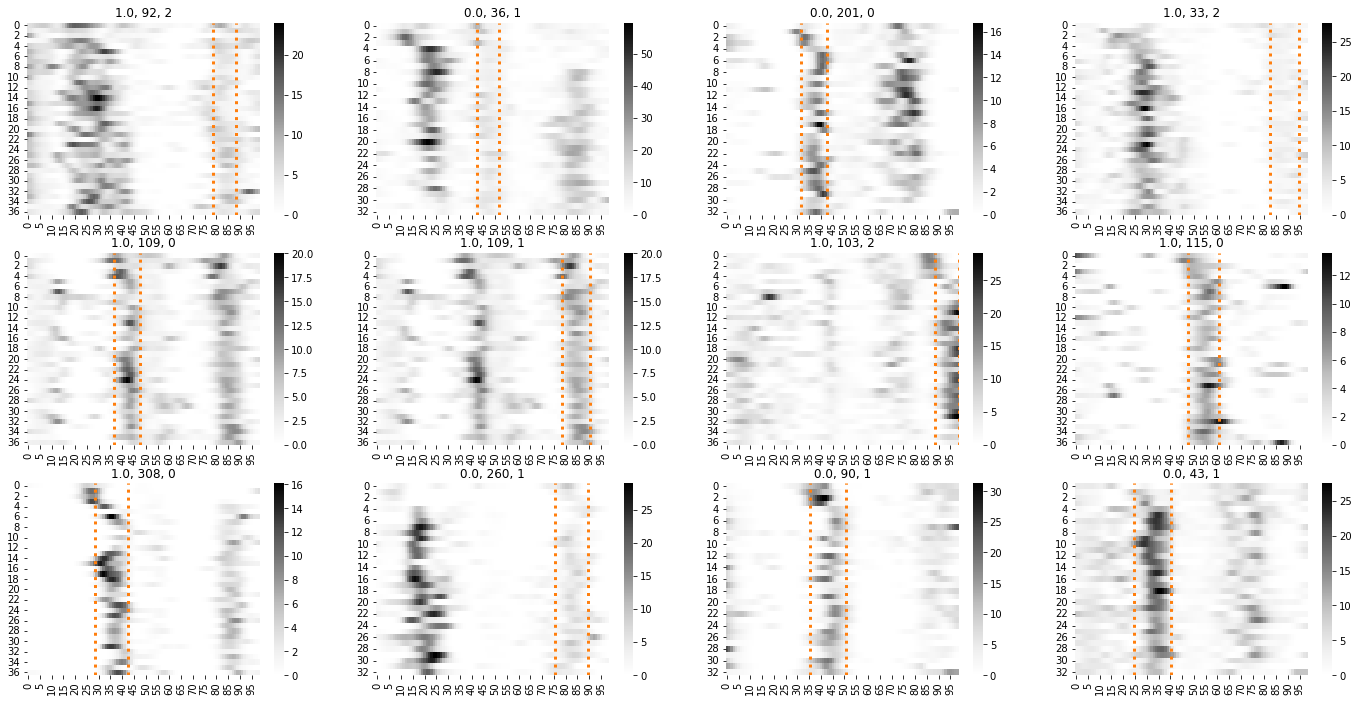

In [470]:
mm=20
toplot_inds=range((mm)*12,(mm+1)*12)
nplots=len(toplot_inds)
fig,axs=ph.subplots_wrapper(nplots)
sorted_inds=W_df_tsp.index
for ii,jj in enumerate(toplot_inds):
    ani,sess,ti,tt,uid,field_id=sorted_inds[jj]
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

    fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
    ax=axs.ravel()[ii]
    ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    ax.set_title(f'{tt}, {uid}, {field_id}')

# tsp without NMF

In [509]:
per_field_metrics_all

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.696970   0.705983  4.374080   
                                27 0           1.000000   0.227746  6.913563   
                                29 0           0.787879   0.701315  1.986221   
                                   1           1.000000   0.201301  3.270333   
                                   2           1.000000   0.388584  2.973685   
...                                                 ...        ...       ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000   0.432693  3.326442   
                                32 0           0.958333   0.516519  6.448795   
                                38 0           0.833333   0.713964  1.966661   
                                47 0           0.958333   0.610375  2.738613   
                                53 0           0.708333   0.795243  2.527745   

                                     field_width    tot_var       mean  \
e13_26m1 e13_26m1_210913 0 0.0  3  0          16   4.291338   2.979778   
                                27 0          30  54.997992  33.067719   
                                29 0           7  17.511026   6.059328   
                                   1          18  27.155813  26.288630   
                                   2          16  44.745505  17.481232   
...                                          ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0          17  13.526576   8.682727   
                                32 0          21  35.811976  11.835044   
                                38 0           7  42.932386   9.374712   
                                47 0           6  14.870425   6.453665   
                                53 0           6   7.496653   3.517027   

                                       fit_var  resid2_mean  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  2.860527     1.430811       0.666582   
                                27 0  0.000000    54.997992       0.000000   
                                29 0  7.938207     9.572818       0.453326   
                                   1  0.000000    27.155813       0.000000   
                                   2  0.000000    44.745505       0.000000   
...                                        ...          ...            ...   
e14_2m3  e14_2m3_201118  0 both 30 0  0.000000    13.526576       0.000000   
                                32 0  0.000000    35.811976       0.000000   
                                38 0  0.000000    42.932386       0.000000   
                                47 0  0.000000    14.870425       0.000000   
                                53 0  0.000000     7.496653       0.000000   

                                      resid2_mean_ratio  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.333418      1.440154   
                                27 0           1.000000      1.663193   
                                29 0           0.546674      2.889929   
                                   1           1.000000      1.032987   
                                   2           1.000000      2.559631   
...                                                 ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000      1.557872   
                                32 0           1.000000      3.025927   
                                38 0           1.000000      4.579595   
                                47 0           1.000000      2.304183   
                                53 0           1.000000      2.131531   

                                      fit_var_norm  resid2_mean_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.959980          0.480174   
                                27 0      0.000000          1.663193   
                                29 0      1.310081          1.579848   
                                   1      0.000000          1.032987   
              

In [554]:
sess = 'e15_13f1_220117'#'e13_26m1_210913'#
feat_col = ['frac_trial_active','fr_cv_beh','loc_std','field_width','tot_var_norm','fit_var_ratio','log_mean','lap_correlation','si']
# feat_col = ['frac_trial_active','fr_cv_beh','loc_std','fit_var_ratio','resid2_mean_norm','lap_correlation']

data = per_field_metrics_all.loc[(slice(None),sess),feat_col]


data_norm = StandardScaler().fit_transform(data)
# data_norm = MinMaxScaler().fit_transform(data)
data_norm = pd.DataFrame(data_norm,columns=data.columns,index=data.index)


In [555]:
def tsp_from_data(data):
    data_dist=squareform(pdist(data.values))
    tsp_inds,_=tsp.solve_tsp(data_dist)
    data_tsp = data.iloc[tsp_inds]
    return data_tsp,tsp_inds

In [556]:
data_norm_tsp,tsp_inds=tsp_from_data(data_norm)
data_tsp = data.iloc[tsp_inds]

/tmp/ipykernel_1352574/1824895570.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/1824895570.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/1824895570.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/1824895570.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/1824895570.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T


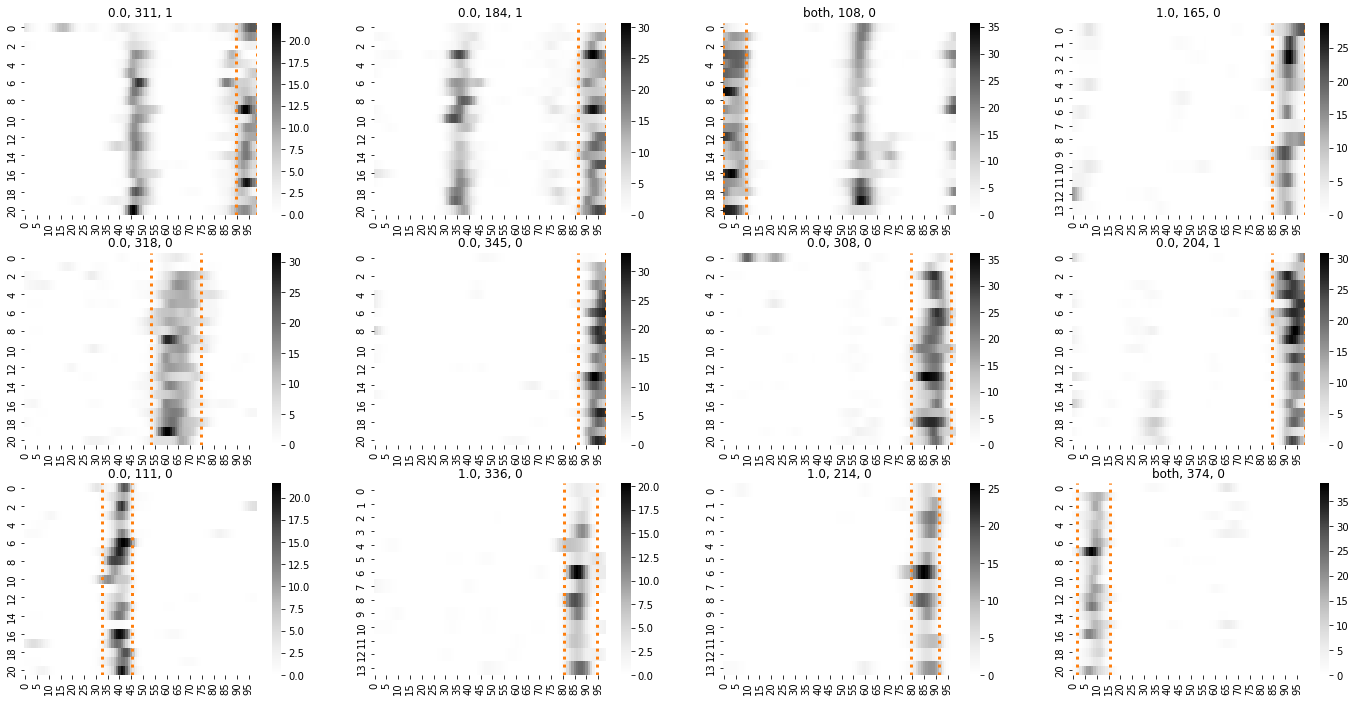

In [550]:
mm=2
toplot_inds=range((mm)*12,(mm+1)*12)
nplots=len(toplot_inds)
fig,axs=ph.subplots_wrapper(nplots)
sorted_inds=data_tsp.index
for ii,jj in enumerate(toplot_inds):
    ani,sess,ti,tt,uid,field_id=sorted_inds[jj]
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

    fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
    ax=axs.ravel()[ii]
    ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    ax.set_title(f'{tt}, {uid}, {field_id}')

/tmp/ipykernel_1352574/3029043361.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/3029043361.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/3029043361.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/3029043361.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1352574/3029043361.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T


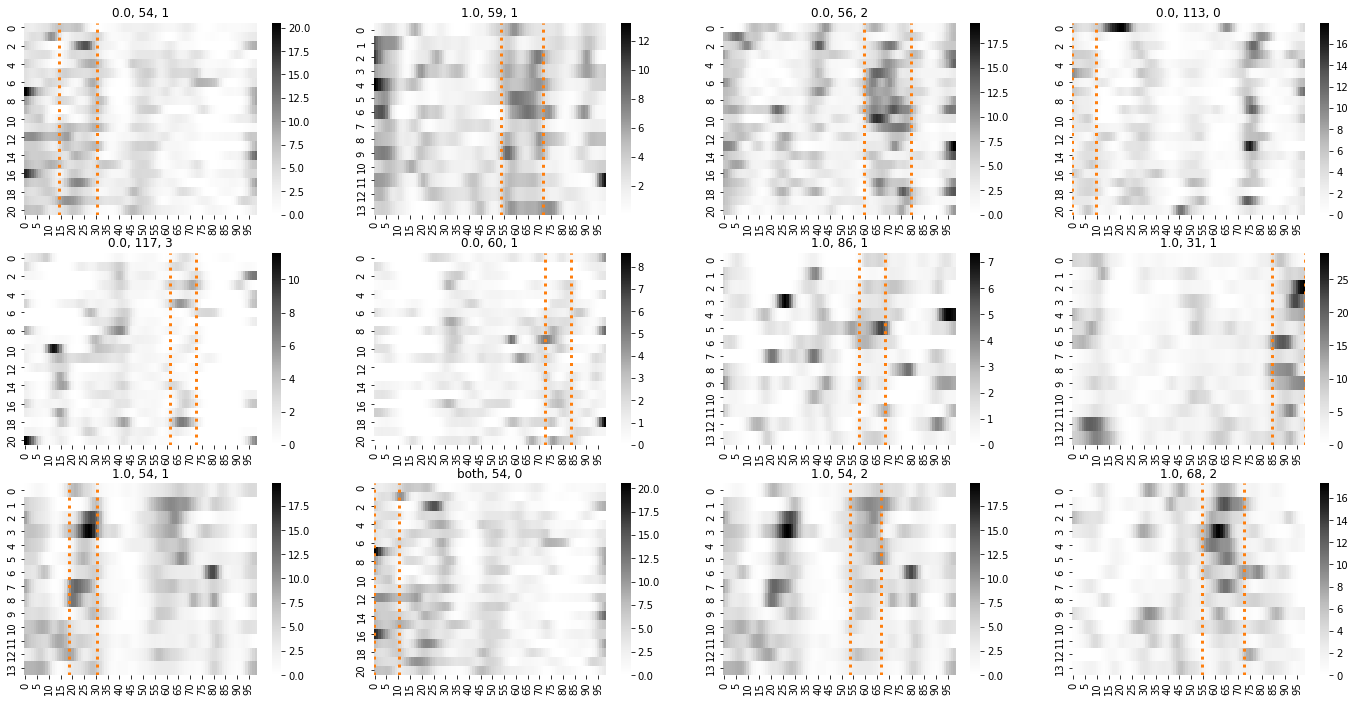

In [585]:
# ma=(data_norm_tsp['fit_var_ratio'] < 1.)&(data_norm_tsp['si'] <-1. ) 
# ma=(data_norm_tsp['fit_var_ratio'] > 1.)&(data_norm_tsp['fr_cv_beh'] <1. )&(data_norm_tsp['fr_cv_beh'] >0.5 )
# ma=(data_norm_tsp['fit_var_ratio'] < 1.)&(data_norm_tsp['si'] >1.)&(data_norm_tsp['fr_cv_beh']<0) 
# ma=(data_norm_tsp['fit_var_ratio'] < 1.)&(data_norm_tsp['si'] >1.)&(data_norm_tsp['frac_trial_active']>0.5) 
# ma=(data_norm_tsp['fit_var_ratio'] < 1.)&(data_norm_tsp['si'] >1.)&(data_norm_tsp['loc_std']>0.5) 
ma=(data_norm_tsp['si'] <-1.)&(data_norm_tsp['loc_std']>0.5) 
data_norm_tsp.loc[ma]
toplot_inds=data_norm_tsp.loc[ma].index[:12]
nplots=len(toplot_inds)
fig,axs=ph.subplots_wrapper(nplots)

for ii,jj in enumerate(toplot_inds):
    ani,sess,ti,tt,uid,field_id=jj
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

    fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
    ax=axs.ravel()[ii]
    ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    ax.set_title(f'{tt}, {uid}, {field_id}')

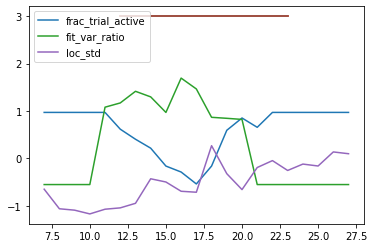

In [547]:
fig,ax=plt.subplots()
for key in ['frac_trial_active','fit_var_ratio','loc_std']:
    toshow_inds=np.arange(toplot_inds[0]-5,toplot_inds[-1]+5)
    ax.plot(toshow_inds,data_norm_tsp.iloc[toshow_inds][key],label=key)
    ax.plot(toplot_inds,3*np.ones(len(toplot_inds)))
plt.legend()

<Axes: >

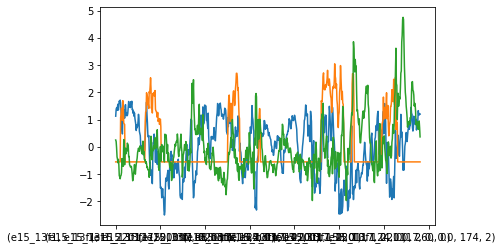

In [518]:
data_norm_tsp['lap_correlation'].plot()
data_norm_tsp['fit_var_ratio'].plot()
data_norm_tsp['loc_std'].plot()
# data_norm_tsp['si'].plot()


In [549]:
data_norm_tsp.iloc[toplot_inds]

frac_trial_active  fr_cv_beh   loc_std  \
e15_13f1 e15_13f1_220117 0 both 267 0           0.615835  -0.536282 -1.045492   
                           0.0  235 0           0.403416   0.045268 -0.949531   
                                151 0           0.214599  -0.234768 -0.431521   
                                221 0          -0.163035  -0.045675 -0.499421   
                           1.0  120 0          -0.288913   0.380337 -0.695066   
                           0.0  347 0          -0.540669   0.079129 -0.715395   
                                105 0          -0.163035  -0.287230  0.266927   
                                40  0           0.592233  -0.491190 -0.323836   
                           both 67  0           0.851857  -0.961683 -0.659720   
                           1.0  341 0           0.655172  -0.501264 -0.193602   
                                251 0           0.969867  -0.610009 -0.047874   
                           0.0  224 0           0.969867  -0.717593 -0.255795   

                                       fit_var_ratio  resid2_mean_norm  \
e15_13f1 e15_13f1_220117 0 both 267 0       1.169644         -0.187243   
                           0.0  235 0       1.415367         -0.371219   
                                151 0       1.297606         -0.351794   
                                221 0       0.969279         -0.621796   
                           1.0  120 0       1.694252         -0.473352   
                           0.0  347 0       1.464835         -0.748951   
                                105 0       0.866409         -0.795753   
                                40  0       0.845230         -0.679465   
                           both 67  0       0.821728         -0.356832   
                           1.0  341 0      -0.553454         -0.228960   
                                251 0      -0.553454          0.092679   
                           0.0  224 0      -0.553454          0.141430   

                                       lap_correlation  
e15_13f1 e15_13f1_220117 0 both 267 0         1.280542  
                           0.0  235 0         0.970136  
                                151 0         0.642359  
                                221 0         0.473611  
                           1.0  120 0         1.114788  
                           0.0  347 0         1.044724  
                                105 0         1.123273  
                                40  0         1.349226  
                           both 67  0         1.051883  
                           1.0  341 0         1.487665  
                                251 0         1.548944  
                           0.0  224 0         1.266881

In [505]:
data_tsp.iloc[toplot_inds]

frac_trial_active  fr_cv_beh   loc_std  \
e15_13f1 e15_13f1_220117 0 1.0  137 0           0.666667   0.827217  2.958040   
                                142 2           0.500000   0.862163  3.605551   
                                80  2           0.500000   0.771902  3.342790   
                                60  2           0.500000   0.496339  3.752777   
                           0.0  104 0           0.300000   0.609946  2.702825   
                                226 2           0.300000   0.687618  2.433862   
                           both 370 0           0.406250   0.767608  2.818251   
                                226 0           0.468750   0.649431  2.788043   
                           1.0  309 0           0.583333   0.687162  2.745520   
                                86  0           0.583333   0.477410  2.678478   
                           0.0  89  0           0.500000   0.442999  2.481511   
                                64  0           0.400000   0.417479  2.257152   

                                      field_width  tot_var_norm  \
e15_13f1 e15_13f1_220117 0 1.0  137 0           9      2.194323   
                                142 2          11      1.983120   
                                80  2          10      1.497114   
                                60  2          10      0.444183   
                           0.0  104 0           9      0.569526   
                                226 2           7      0.869479   
                           both 370 0           7      1.070827   
                                226 0           9      0.870744   
                           1.0  309 0           7      0.785912   
                                86  0           7      0.508839   
                           0.0  89  0           8      0.388562   
                                64  0           8      0.361688   

                                       fit_var_ratio  log_mean  \
e15_13f1 e15_13f1_220117 0 1.0  137 0   5.270916e-01  1.252262   
                                142 2   5.935711e-01  1.068305   
                                80  2   8.141595e-01  1.008347   
                                60  2   7.032844e-01  0.676484   
                           0.0  104 0   5.464137e-01  0.477112   
                                226 2   4.023065e-01  0.660475   
                           both 370 0   2.567478e-01  0.629132   
                                226 0   0.000000e+00  0.756659   
                           1.0  309 0   1.382047e-31  0.596470   
                                86  0   1.591379e-31  0.890148   
                           0.0  89  0   0.000000e+00  0.734364   
                                64  0   2.496127e-31  0.781359   

                                       lap_correlation        si  
e15_13f1 e15_13f1_220117 0 1.0  137 0         0.331426  0.825989  
                                142 2         0.219487  0.380360  
                                80  2         0.274157  0.207207  
                                60  2         0.079663  0.165671  
                           0.0  104 0         0.251283  0.204280  
                                226 2         0.242062  0.465913  
                           both 370 0         0.380645  0.393726  
                                226 0         0.357536  0.586032  
                           1.0  309 0         0.263288  0.465260  
                                86  0         0.103316  0.119429  
                           0.0  89  0         0.272462  0.330449  
                                64  0         0.416522  0.253554

In [380]:
row.name

('e13_26m1', 'e13_26m1_210913', 0, 0.0, 123, 1)

In [374]:
fr_map_trial_df_all.loc[ani,s]

0         1         2   \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  0.000000   
                                    1   0.000000  0.000000  0.000000   
                                    2   0.000000  0.000000  0.000000   
                                    3   0.000000  0.000000  0.000000   
                                    4   0.000000  0.000000  0.000000   
...                                          ...       ...       ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.228908  0.107838  0.319165   
                                    95  0.437416  0.054944  0.273498   
                                    96  0.668342  0.025218  0.214291   
                                    97  0.845171  0.010261  0.152462   
                                    98  0.934170  0.004174  0.109505   

                                              3         4    5    6    7   \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  0.0  0.0  0.0   
                                    1   0.000000  0.000000  0.0  0.0  0.0   
                                    2   0.000000  0.000000  0.0  0.0  0.0   
                                    3   0.000000  0.000000  0.0  0.0  0.0   
                                    4   0.000000  0.000000  0.0  0.0  0.0   
...                                          ...       ...  ...  ...  ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.061053  0.000326  0.0  0.0  0.0   
                                    95  0.025358  0.000000  0.0  0.0  0.0   
                                    96  0.008699  0.000000  0.0  0.0  0.0   
                                    97  0.002511  0.000000  0.0  0.0  0.0   
                                    98  0.000763  0.000000  0.0  0.0  0.0   

                                              8         9   ...   27   28  \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  ...  0.0  0.0   
                                    1   0.000000  0.000000  ...  0.0  0.0   
                                    2   0.000000  0.000000  ...  0.0  0.0   
                                    3   0.000000  0.000000  ...  0.0  0.0   
                                    4   0.000000  0.000000  ...  0.0  0.0   
...                                          ...       ...  ...  ...  ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.210997  0.637280  ...  NaN  NaN   
                                    95  0.142821  0.533430  ...  NaN  NaN   
                                    96  0.082327  0.446984  ...  NaN  NaN   
                                    97  0.039830  0.391175  ...  NaN  NaN   
                                    98  0.019110  0.364898  ...  NaN  NaN   

                                         29   30   31        32  33  34  35  \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.0  0.0  0.0  1.388314 NaN NaN NaN   
                                    1   0.0  0.0  0.0  1.133691 NaN NaN NaN   
                                    2   0.0  0.0  0.0  0.824918 NaN NaN NaN   
                                    3   0.0  0.0  0.0  0.603731 NaN NaN NaN   
                                    4   0.0  0.0  0.0  0.482523 NaN NaN NaN   
...                                     ...  ...  ...       ...  ..  ..  ..   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    95  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    96  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    97  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    98  NaN  NaN  NaN       NaN NaN NaN NaN   

                                        36  
e13_26m1 e13_26m1_210913 0 0.0 1.0  0  NaN  
                                    1  NaN  
                                    2  NaN  
                                    3  NaN  
                                    4  NaN  
...                                     ..  
e14_2m3  e14_2m3_201118  0 1.0 54.0 94 NaN  
                      

<Axes: >

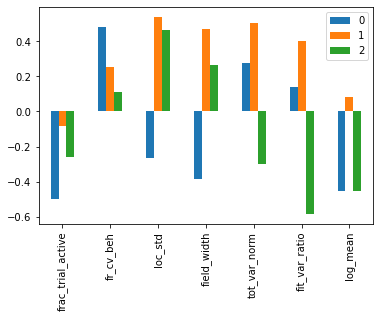

In [291]:
H_df.T.plot(kind='bar')

<Axes: xlabel='fit_var_ratio', ylabel='frac_trial_active'>

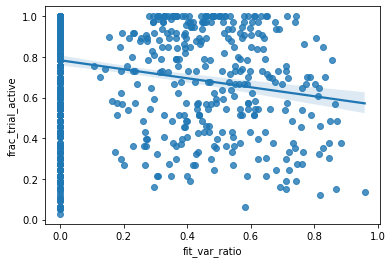

In [294]:
sns.regplot(data=data,x='fit_var_ratio',y='frac_trial_active')

(0.0, 1.0)

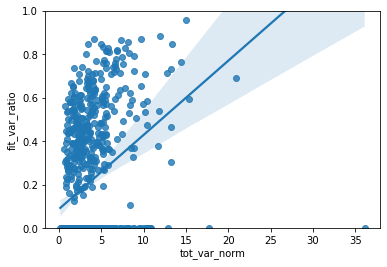

In [314]:
ax=sns.regplot(data=data,x='tot_var_norm',y='fit_var_ratio')
ax.set_ylim([0,1])

In [315]:
data['tot_var_norm'].sort_values()

e13_26m1  e13_26m1_210913  0  0.0  102  3     0.163500
                                   189  1     0.304150
                              1.0  54   2     0.336604
                              0.0  145  1     0.360604
                              1.0  33   2     0.379790
                                               ...    
                                   208  0    15.017342
                                   374  2    15.389396
                                   456  0    17.678051
                                   274  0    20.900307
                                   426  0    36.108241
Name: tot_var_norm, Length: 820, dtype: float64

In [299]:
data.query('fit_var_ratio==0').sort_values('frac_trial_active')

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0 315 0           0.060606   4.477899  0.969223   
                               102 3           0.060606   0.349818  1.748917   
                               183 1           0.060606   3.159795  0.726918   
                               369 1           0.060606   4.210077  0.726918   
                               479 2           0.060606   4.260241  0.726918   
...                                                 ...        ...       ...   
                               222 0           1.000000   0.519891  1.301951   
                               225 0           1.000000   0.377766  4.492629   
                               226 0           1.000000   0.607037  6.929843   
                               237 1           1.000000   0.510662  3.033899   
                               211 0           1.000000   0.502391  2.973367   

                                     field_width  tot_var_norm  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0 315 0           5      4.930611            0.0   
                               102 3           5      0.163500            0.0   
                               183 1           4      5.899641            0.0   
                               369 1           4      6.617800            0.0   
                               479 2           4      9.895523            0.0   
...                                          ...           ...            ...   
                               222 0           6      1.620776            0.0   
                               225 0          24      4.139763            0.0   
                               226 0          29      4.222100            0.0   
                               237 1          13      2.891006            0.0   
                               211 0          12      3.450198            0.0   

                                      log_mean  
e13_26m1 e13_26m1_210913 0 0.0 315 0 -1.372073  
                               102 3  0.320509  
                               183 1 -0.495351  
                               369 1 -0.954427  
                               479 2 -0.575797  
...                                        ...  
                               222 0  1.821947  
                               225 0  3.398369  
                               226 0  2.469435  
                               237 1  2.436470  
                               211 0  2.645958  

[296 rows x 7 columns]

In [312]:
ma=(data['tot_var_norm']>3.4)&(data['fit_var_ratio']>0.6)
data.loc[ma]

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  68  0           0.848485   0.881727  5.916720   
                                84  0           1.000000   0.436231  6.758132   
                                93  2           0.909091   0.697880  2.348839   
                                110 1           0.484848   1.225184  3.702732   
                                122 1           0.969697   0.823691  4.085961   
...                                                  ...        ...       ...   
                           1.0  476 0           0.378378   1.640968  6.730773   
                           both 82  0           0.728571   1.139450  4.702759   
                                216 0           1.000000   0.423239  3.962662   
                                356 0           0.585714   1.078240  5.194857   
                                443 0           0.714286   0.823943  6.241334   

                                      field_width  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  68  0          18      5.762207   
                                84  0          27      3.469932   
                                93  2           7      7.250285   
                                110 1          11      6.733496   
                                122 1          13      3.691722   
...                                           ...           ...   
                           1.0  476 0          19     13.252206   
                           both 82  0           5     12.791463   
                                216 0          28      5.048415   
                                356 0          16      6.965341   
                                443 0          18      9.697473   

                                       fit_var_ratio  log_mean  
e13_26m1 e13_26m1_210913 0 0.0  68  0       0.829054  2.033837  
                                84  0       0.648809  2.934071  
                                93  2       0.637029  2.731229  
                                110 1       0.731400  1.531684  
                                122 1       0.621960  1.724784  
...                                              ...       ...  
                           1.0  476 0       0.734333  1.620990  
                           both 82  0       0.712360  2.302076  
                                216 0       0.610448  3.353099  
                                356 0       0.613721  1.804675  
                                443 0       0.653086  2.673562  

[67 rows x 7 columns]

In [308]:
uid=211
stab_all.loc[slice(None),sess,0,0,uid]

e13_26m1    0.72985
dtype: float64

In [309]:
s_i_all.loc[slice(None),sess,0,0,uid]

e13_26m1    1.005087
dtype: float64

In [179]:
model.explained_variance_ratio_.sum()

0.5532666029187807

In [172]:
pipeline[1].explined_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explined_variance_ratio_'

In [108]:
ani='e13_26m1'
sess='e13_26m1_210913'
spk_beh_df = spk_beh_df_all.loc[ani,sess]
cell_cols = fr_map_trial_df_all.loc[ani,sess,:].index.get_level_values(2).unique()

/tmp/ipykernel_1352574/3107284095.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


In [111]:
eps = 1e-10
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=gauss_width,trialtype_key='trial_type',speed_key=speed_key,speed_thresh=speed_thresh,order=['smooth','divide','average'])
si_d = {}
for k in fr_map_dict.keys():
    occu = fr_map_dict[k][-1]
    occu_p = np.squeeze(occu / occu.sum())
    fr_map = fr_map_dict[k][0]

    fr_mean = np.average(fr_map,weights=occu_p,axis=1)

    div = (fr_map / fr_mean[:,None])
    si = np.average(div*np.log2(div+eps),weights=occu_p,axis=1)
    si = pd.Series(si,fr_map.index)
    si_d[k] = si
si_d = pd.concat(si_d,axis=0)

In [125]:
np.average((np.log2(div.loc[2]+eps) * div.loc[2]),weights=occu_p)

2.221757039264044

<Axes: xlabel='lin_binned'>

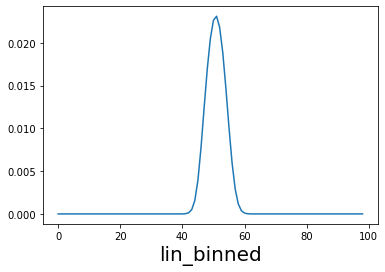

In [117]:
fr_map.loc[2].plot()

In [112]:
si_d

0  0.0  1.0      1.609414
        2.0           NaN
        3.0      3.372180
        27.0     0.026260
        29.0     0.979341
                   ...   
   1.0  476.0    1.995012
        477.0    1.876547
        478.0    1.626393
        479.0    1.403254
        480.0    1.316847
Length: 844, dtype: float64

In [114]:
s_i_all.iloc[:10]

e13_26m1  e13_26m1_210913  0  0.0  1.0     1.609414
                                   2.0          NaN
                                   3.0     3.372180
                                   27.0    0.026260
                                   29.0    0.979341
                                   30.0    0.705295
                                   31.0    2.039583
                                   32.0    0.406504
                                   33.0    0.361134
                                   34.0    0.142256
dtype: float64